## Setup

In [1]:
from OPMD_acq.testbench_funcs import OPMD_TestBench, pm_modes
from experiment.experiment import tb 

/Users/mingyu/Desktop/OPMD_acq/OPMD_acq/testbench_funcs.py:101: UserWarning: no Archon connected to server, CCD functionality will be disabled...
  warn("no Archon connected to server, CCD functionality will be disabled...")


In [2]:
from time import sleep
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

### Slow Source

In [3]:
# tb.start_lamp()
# tb.wavelength = 600 
# print(tb.wavelength)
# tb.get_lamp_current()
# tb.set_lamp_current(10.0)
# with tb.lamp_power_context(stoponsuccess=True) as session: 
#     pass 

In [4]:
# tb.stop_lamp()
tb.get_lamp_current()

10.0

### Power Meter

In [5]:
# tb.setup_photodiode(pm_modes.SINGLESHOT_MANUAL, 1)
# tb.photodiode_units = 'A'
# print(tb.photodiode_units)
# tb.measure_photodiode(1)
# tb.measure_light_current_instantaneous(1)
# tb.get_photodiode_responsivity(1)

### Spectrometer

In [6]:
# tb.read_spectrum(100)

### Parameter

In [7]:
wls = [460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700]
exposure = 300
trials = 400

## 1. Powermeter

Setting the wavelength of the slow source to: 460.00
2020-02-18 00:22:22.928707 Working on trial 0
2020-02-18 00:22:23.117216 Working on trial 1
2020-02-18 00:22:23.326321 Working on trial 2
2020-02-18 00:22:23.518059 Working on trial 3
2020-02-18 00:22:23.729295 Working on trial 4
2020-02-18 00:22:23.940687 Working on trial 5
2020-02-18 00:22:24.129481 Working on trial 6
2020-02-18 00:22:24.317114 Working on trial 7
2020-02-18 00:22:24.524888 Working on trial 8
2020-02-18 00:22:24.733258 Working on trial 9
2020-02-18 00:22:24.922038 Working on trial 10
2020-02-18 00:22:25.129031 Working on trial 11
2020-02-18 00:22:25.336779 Working on trial 12
2020-02-18 00:22:25.525722 Working on trial 13
2020-02-18 00:22:25.733317 Working on trial 14
2020-02-18 00:22:25.941727 Working on trial 15
2020-02-18 00:22:26.129504 Working on trial 16
2020-02-18 00:22:26.297567 Working on trial 17
2020-02-18 00:22:26.509450 Working on trial 18
2020-02-18 00:22:26.697130 Working on trial 19
2020-02-18 00:22:

2020-02-18 00:22:56.992865 Working on trial 173
2020-02-18 00:22:57.181508 Working on trial 174
2020-02-18 00:22:57.369115 Working on trial 175
2020-02-18 00:22:57.537247 Working on trial 176
2020-02-18 00:22:57.723862 Working on trial 177
2020-02-18 00:22:57.932195 Working on trial 178
2020-02-18 00:22:58.142922 Working on trial 179
2020-02-18 00:22:58.340421 Working on trial 180
2020-02-18 00:22:58.553503 Working on trial 181
2020-02-18 00:22:58.745168 Working on trial 182
2020-02-18 00:22:58.912957 Working on trial 183
2020-02-18 00:22:59.120802 Working on trial 184
2020-02-18 00:22:59.332694 Working on trial 185
2020-02-18 00:22:59.541005 Working on trial 186
2020-02-18 00:22:59.849298 Working on trial 187
2020-02-18 00:23:00.040626 Working on trial 188
2020-02-18 00:23:00.248807 Working on trial 189
2020-02-18 00:23:00.440875 Working on trial 190
2020-02-18 00:23:00.629289 Working on trial 191
2020-02-18 00:23:00.836505 Working on trial 192
2020-02-18 00:23:01.004831 Working on tr

2020-02-18 00:23:30.419589 Working on trial 344
2020-02-18 00:23:30.607847 Working on trial 345
2020-02-18 00:23:30.800209 Working on trial 346
2020-02-18 00:23:31.007777 Working on trial 347
2020-02-18 00:23:31.200978 Working on trial 348
2020-02-18 00:23:31.388021 Working on trial 349
2020-02-18 00:23:31.595756 Working on trial 350
2020-02-18 00:23:31.804005 Working on trial 351
2020-02-18 00:23:32.012043 Working on trial 352
2020-02-18 00:23:32.220401 Working on trial 353
2020-02-18 00:23:32.428897 Working on trial 354
2020-02-18 00:23:32.603669 Working on trial 355
2020-02-18 00:23:32.816217 Working on trial 356
2020-02-18 00:23:33.024646 Working on trial 357
2020-02-18 00:23:33.192410 Working on trial 358
2020-02-18 00:23:33.380398 Working on trial 359
2020-02-18 00:23:33.589402 Working on trial 360
2020-02-18 00:23:33.776695 Working on trial 361
2020-02-18 00:23:33.990998 Working on trial 362
2020-02-18 00:23:34.200434 Working on trial 363
2020-02-18 00:23:34.408616 Working on tr

2020-02-18 00:24:18.976198 Working on trial 116
2020-02-18 00:24:19.164329 Working on trial 117
2020-02-18 00:24:19.372361 Working on trial 118
2020-02-18 00:24:19.579875 Working on trial 119
2020-02-18 00:24:19.828043 Working on trial 120
2020-02-18 00:24:20.036115 Working on trial 121
2020-02-18 00:24:20.223974 Working on trial 122
2020-02-18 00:24:20.391630 Working on trial 123
2020-02-18 00:24:20.579238 Working on trial 124
2020-02-18 00:24:20.795225 Working on trial 125
2020-02-18 00:24:20.962886 Working on trial 126
2020-02-18 00:24:21.151782 Working on trial 127
2020-02-18 00:24:21.359255 Working on trial 128
2020-02-18 00:24:21.548161 Working on trial 129
2020-02-18 00:24:21.715904 Working on trial 130
2020-02-18 00:24:21.903377 Working on trial 131
2020-02-18 00:24:22.111917 Working on trial 132
2020-02-18 00:24:22.303927 Working on trial 133
2020-02-18 00:24:22.499554 Working on trial 134
2020-02-18 00:24:22.687528 Working on trial 135
2020-02-18 00:24:22.896281 Working on tr

2020-02-18 00:24:52.523805 Working on trial 287
2020-02-18 00:24:52.715805 Working on trial 288
2020-02-18 00:24:52.922470 Working on trial 289
2020-02-18 00:24:53.115226 Working on trial 290
2020-02-18 00:24:53.323792 Working on trial 291
2020-02-18 00:24:53.511560 Working on trial 292
2020-02-18 00:24:53.706505 Working on trial 293
2020-02-18 00:24:53.895337 Working on trial 294
2020-02-18 00:24:54.083036 Working on trial 295
2020-02-18 00:24:54.270643 Working on trial 296
2020-02-18 00:24:54.499629 Working on trial 297
2020-02-18 00:24:54.687611 Working on trial 298
2020-02-18 00:24:54.895545 Working on trial 299
2020-02-18 00:24:55.103217 Working on trial 300
2020-02-18 00:24:55.291070 Working on trial 301
2020-02-18 00:24:55.480205 Working on trial 302
2020-02-18 00:24:55.670949 Working on trial 303
2020-02-18 00:24:55.859303 Working on trial 304
2020-02-18 00:24:56.046605 Working on trial 305
2020-02-18 00:24:56.234560 Working on trial 306
2020-02-18 00:24:56.422728 Working on tr

2020-02-18 00:25:38.214253 Working on trial 58
2020-02-18 00:25:38.402816 Working on trial 59
2020-02-18 00:25:38.609846 Working on trial 60
2020-02-18 00:25:38.798492 Working on trial 61
2020-02-18 00:25:38.987735 Working on trial 62
2020-02-18 00:25:39.198529 Working on trial 63
2020-02-18 00:25:39.406165 Working on trial 64
2020-02-18 00:25:39.614253 Working on trial 65
2020-02-18 00:25:39.823187 Working on trial 66
2020-02-18 00:25:40.010240 Working on trial 67
2020-02-18 00:25:40.198480 Working on trial 68
2020-02-18 00:25:40.414441 Working on trial 69
2020-02-18 00:25:40.622699 Working on trial 70
2020-02-18 00:25:40.830177 Working on trial 71
2020-02-18 00:25:41.018960 Working on trial 72
2020-02-18 00:25:41.206309 Working on trial 73
2020-02-18 00:25:41.395076 Working on trial 74
2020-02-18 00:25:41.563131 Working on trial 75
2020-02-18 00:25:41.750641 Working on trial 76
2020-02-18 00:25:41.962425 Working on trial 77
2020-02-18 00:25:42.151534 Working on trial 78
2020-02-18 00

2020-02-18 00:26:12.370320 Working on trial 230
2020-02-18 00:26:12.558592 Working on trial 231
2020-02-18 00:26:12.765953 Working on trial 232
2020-02-18 00:26:12.954043 Working on trial 233
2020-02-18 00:26:13.122680 Working on trial 234
2020-02-18 00:26:13.309860 Working on trial 235
2020-02-18 00:26:13.502153 Working on trial 236
2020-02-18 00:26:13.710160 Working on trial 237
2020-02-18 00:26:13.897617 Working on trial 238
2020-02-18 00:26:14.086245 Working on trial 239
2020-02-18 00:26:14.274747 Working on trial 240
2020-02-18 00:26:14.461873 Working on trial 241
2020-02-18 00:26:14.654271 Working on trial 242
2020-02-18 00:26:14.861423 Working on trial 243
2020-02-18 00:26:15.050194 Working on trial 244
2020-02-18 00:26:15.237889 Working on trial 245
2020-02-18 00:26:15.426357 Working on trial 246
2020-02-18 00:26:15.613753 Working on trial 247
2020-02-18 00:26:15.805962 Working on trial 248
2020-02-18 00:26:16.013934 Working on trial 249
2020-02-18 00:26:16.221182 Working on tr

2020-02-18 00:26:56.161401 Working on trial 0
2020-02-18 00:26:56.330235 Working on trial 1
2020-02-18 00:26:56.518198 Working on trial 2
2020-02-18 00:26:56.705863 Working on trial 3
2020-02-18 00:26:56.893311 Working on trial 4
2020-02-18 00:26:57.065117 Working on trial 5
2020-02-18 00:26:57.253453 Working on trial 6
2020-02-18 00:26:57.442033 Working on trial 7
2020-02-18 00:26:57.609347 Working on trial 8
2020-02-18 00:26:57.797317 Working on trial 9
2020-02-18 00:26:57.967548 Working on trial 10
2020-02-18 00:26:58.167235 Working on trial 11
2020-02-18 00:26:58.337380 Working on trial 12
2020-02-18 00:26:58.526304 Working on trial 13
2020-02-18 00:26:58.693980 Working on trial 14
2020-02-18 00:26:58.861266 Working on trial 15
2020-02-18 00:26:59.029436 Working on trial 16
2020-02-18 00:26:59.217836 Working on trial 17
2020-02-18 00:26:59.385659 Working on trial 18
2020-02-18 00:26:59.553984 Working on trial 19
2020-02-18 00:26:59.846278 Working on trial 20
2020-02-18 00:27:00.028

2020-02-18 00:27:27.736887 Working on trial 174
2020-02-18 00:27:27.925684 Working on trial 175
2020-02-18 00:27:28.092755 Working on trial 176
2020-02-18 00:27:28.281155 Working on trial 177
2020-02-18 00:27:28.473331 Working on trial 178
2020-02-18 00:27:28.641960 Working on trial 179
2020-02-18 00:27:28.857370 Working on trial 180
2020-02-18 00:27:29.025299 Working on trial 181
2020-02-18 00:27:29.193648 Working on trial 182
2020-02-18 00:27:29.381365 Working on trial 183
2020-02-18 00:27:29.548914 Working on trial 184
2020-02-18 00:27:29.736756 Working on trial 185
2020-02-18 00:27:29.925152 Working on trial 186
2020-02-18 00:27:30.104999 Working on trial 187
2020-02-18 00:27:30.294390 Working on trial 188
2020-02-18 00:27:30.464704 Working on trial 189
2020-02-18 00:27:30.632620 Working on trial 190
2020-02-18 00:27:30.800577 Working on trial 191
2020-02-18 00:27:30.989073 Working on trial 192
2020-02-18 00:27:31.158451 Working on trial 193
2020-02-18 00:27:31.328273 Working on tr

2020-02-18 00:27:58.973327 Working on trial 345
2020-02-18 00:27:59.181089 Working on trial 346
2020-02-18 00:27:59.352550 Working on trial 347
2020-02-18 00:27:59.541694 Working on trial 348
2020-02-18 00:27:59.844056 Working on trial 349
2020-02-18 00:28:00.065286 Working on trial 350
2020-02-18 00:28:00.233234 Working on trial 351
2020-02-18 00:28:00.441435 Working on trial 352
2020-02-18 00:28:00.627981 Working on trial 353
2020-02-18 00:28:00.817198 Working on trial 354
2020-02-18 00:28:00.985048 Working on trial 355
2020-02-18 00:28:01.171639 Working on trial 356
2020-02-18 00:28:01.361468 Working on trial 357
2020-02-18 00:28:01.528452 Working on trial 358
2020-02-18 00:28:01.701246 Working on trial 359
2020-02-18 00:28:01.888683 Working on trial 360
2020-02-18 00:28:02.080760 Working on trial 361
2020-02-18 00:28:02.249193 Working on trial 362
2020-02-18 00:28:02.416416 Working on trial 363
2020-02-18 00:28:02.584071 Working on trial 364
2020-02-18 00:28:02.753278 Working on tr

2020-02-18 00:28:41.936087 Working on trial 117
2020-02-18 00:28:42.103977 Working on trial 118
2020-02-18 00:28:42.276324 Working on trial 119
2020-02-18 00:28:42.483496 Working on trial 120
2020-02-18 00:28:42.652605 Working on trial 121
2020-02-18 00:28:42.840198 Working on trial 122
2020-02-18 00:28:43.028279 Working on trial 123
2020-02-18 00:28:43.195818 Working on trial 124
2020-02-18 00:28:43.368147 Working on trial 125
2020-02-18 00:28:43.555720 Working on trial 126
2020-02-18 00:28:43.749736 Working on trial 127
2020-02-18 00:28:43.941268 Working on trial 128
2020-02-18 00:28:44.111891 Working on trial 129
2020-02-18 00:28:44.279962 Working on trial 130
2020-02-18 00:28:44.468915 Working on trial 131
2020-02-18 00:28:44.676280 Working on trial 132
2020-02-18 00:28:44.844232 Working on trial 133
2020-02-18 00:28:45.032533 Working on trial 134
2020-02-18 00:28:45.223983 Working on trial 135
2020-02-18 00:28:45.412535 Working on trial 136
2020-02-18 00:28:45.599882 Working on tr

2020-02-18 00:29:13.547094 Working on trial 289
2020-02-18 00:29:13.736051 Working on trial 290
2020-02-18 00:29:13.923416 Working on trial 291
2020-02-18 00:29:14.111942 Working on trial 292
2020-02-18 00:29:14.401052 Working on trial 293
2020-02-18 00:29:17.632648 Working on trial 294
2020-02-18 00:29:17.871727 Working on trial 295
2020-02-18 00:29:18.044312 Working on trial 296
2020-02-18 00:29:18.259899 Working on trial 297
2020-02-18 00:29:18.448088 Working on trial 298
2020-02-18 00:29:18.635888 Working on trial 299
2020-02-18 00:29:18.823584 Working on trial 300
2020-02-18 00:29:18.991519 Working on trial 301
2020-02-18 00:29:19.179641 Working on trial 302
2020-02-18 00:29:19.387500 Working on trial 303
2020-02-18 00:29:19.575572 Working on trial 304
2020-02-18 00:29:19.827758 Working on trial 305
2020-02-18 00:29:19.995928 Working on trial 306
2020-02-18 00:29:20.183649 Working on trial 307
2020-02-18 00:29:20.391448 Working on trial 308
2020-02-18 00:29:20.560039 Working on tr

2020-02-18 00:30:00.176099 Working on trial 61
2020-02-18 00:30:00.366662 Working on trial 62
2020-02-18 00:30:00.555214 Working on trial 63
2020-02-18 00:30:00.736055 Working on trial 64
2020-02-18 00:30:00.910457 Working on trial 65
2020-02-18 00:30:01.079120 Working on trial 66
2020-02-18 00:30:01.247001 Working on trial 67
2020-02-18 00:30:01.435370 Working on trial 68
2020-02-18 00:30:01.623550 Working on trial 69
2020-02-18 00:30:01.791022 Working on trial 70
2020-02-18 00:30:01.959262 Working on trial 71
2020-02-18 00:30:02.127442 Working on trial 72
2020-02-18 00:30:02.315738 Working on trial 73
2020-02-18 00:30:02.507549 Working on trial 74
2020-02-18 00:30:02.699491 Working on trial 75
2020-02-18 00:30:02.866854 Working on trial 76
2020-02-18 00:30:03.054877 Working on trial 77
2020-02-18 00:30:03.243092 Working on trial 78
2020-02-18 00:30:03.431401 Working on trial 79
2020-02-18 00:30:03.616134 Working on trial 80
2020-02-18 00:30:03.822405 Working on trial 81
2020-02-18 00

2020-02-18 00:30:31.478829 Working on trial 233
2020-02-18 00:30:31.671774 Working on trial 234
2020-02-18 00:30:31.862671 Working on trial 235
2020-02-18 00:30:32.050382 Working on trial 236
2020-02-18 00:30:32.218306 Working on trial 237
2020-02-18 00:30:32.387302 Working on trial 238
2020-02-18 00:30:32.594002 Working on trial 239
2020-02-18 00:30:32.762851 Working on trial 240
2020-02-18 00:30:32.950334 Working on trial 241
2020-02-18 00:30:33.138828 Working on trial 242
2020-02-18 00:30:33.306899 Working on trial 243
2020-02-18 00:30:33.494365 Working on trial 244
2020-02-18 00:30:33.663019 Working on trial 245
2020-02-18 00:30:33.830400 Working on trial 246
2020-02-18 00:30:34.019611 Working on trial 247
2020-02-18 00:30:34.207176 Working on trial 248
2020-02-18 00:30:34.395188 Working on trial 249
2020-02-18 00:30:34.582874 Working on trial 250
2020-02-18 00:30:34.770688 Working on trial 251
2020-02-18 00:30:34.939314 Working on trial 252
2020-02-18 00:30:35.106811 Working on tr

2020-02-18 00:31:14.493723 Working on trial 4
2020-02-18 00:31:14.682949 Working on trial 5
2020-02-18 00:31:14.873674 Working on trial 6
2020-02-18 00:31:15.061837 Working on trial 7
2020-02-18 00:31:15.240081 Working on trial 8
2020-02-18 00:31:15.437993 Working on trial 9
2020-02-18 00:31:15.625493 Working on trial 10
2020-02-18 00:31:15.818469 Working on trial 11
2020-02-18 00:31:16.006205 Working on trial 12
2020-02-18 00:31:16.193766 Working on trial 13
2020-02-18 00:31:16.383131 Working on trial 14
2020-02-18 00:31:16.569680 Working on trial 15
2020-02-18 00:31:16.757478 Working on trial 16
2020-02-18 00:31:16.930707 Working on trial 17
2020-02-18 00:31:17.098653 Working on trial 18
2020-02-18 00:31:17.266073 Working on trial 19
2020-02-18 00:31:17.434360 Working on trial 20
2020-02-18 00:31:17.602607 Working on trial 21
2020-02-18 00:31:17.770583 Working on trial 22
2020-02-18 00:31:17.957662 Working on trial 23
2020-02-18 00:31:18.170588 Working on trial 24
2020-02-18 00:31:18

2020-02-18 00:31:46.161429 Working on trial 177
2020-02-18 00:31:46.349447 Working on trial 178
2020-02-18 00:31:46.557004 Working on trial 179
2020-02-18 00:31:46.725596 Working on trial 180
2020-02-18 00:31:46.898676 Working on trial 181
2020-02-18 00:31:47.086834 Working on trial 182
2020-02-18 00:31:47.264760 Working on trial 183
2020-02-18 00:31:47.453146 Working on trial 184
2020-02-18 00:31:47.623740 Working on trial 185
2020-02-18 00:31:47.797311 Working on trial 186
2020-02-18 00:31:47.985427 Working on trial 187
2020-02-18 00:31:48.153089 Working on trial 188
2020-02-18 00:31:48.321802 Working on trial 189
2020-02-18 00:31:48.510858 Working on trial 190
2020-02-18 00:31:48.717296 Working on trial 191
2020-02-18 00:31:48.908687 Working on trial 192
2020-02-18 00:31:49.101043 Working on trial 193
2020-02-18 00:31:49.269527 Working on trial 194
2020-02-18 00:31:49.458252 Working on trial 195
2020-02-18 00:31:49.644878 Working on trial 196
2020-02-18 00:31:49.833094 Working on tr

2020-02-18 00:32:17.352977 Working on trial 349
2020-02-18 00:32:17.540893 Working on trial 350
2020-02-18 00:32:17.709089 Working on trial 351
2020-02-18 00:32:17.877402 Working on trial 352
2020-02-18 00:32:18.066577 Working on trial 353
2020-02-18 00:32:18.254221 Working on trial 354
2020-02-18 00:32:18.422502 Working on trial 355
2020-02-18 00:32:18.591067 Working on trial 356
2020-02-18 00:32:18.758036 Working on trial 357
2020-02-18 00:32:18.947951 Working on trial 358
2020-02-18 00:32:19.119551 Working on trial 359
2020-02-18 00:32:19.307580 Working on trial 360
2020-02-18 00:32:19.515663 Working on trial 361
2020-02-18 00:32:19.753406 Working on trial 362
2020-02-18 00:32:19.924436 Working on trial 363
2020-02-18 00:32:20.096772 Working on trial 364
2020-02-18 00:32:20.288960 Working on trial 365
2020-02-18 00:32:20.456856 Working on trial 366
2020-02-18 00:32:20.644763 Working on trial 367
2020-02-18 00:32:20.833980 Working on trial 368
2020-02-18 00:32:21.041256 Working on tr

2020-02-18 00:33:00.871273 Working on trial 122
2020-02-18 00:33:01.039365 Working on trial 123
2020-02-18 00:33:01.227697 Working on trial 124
2020-02-18 00:33:01.414377 Working on trial 125
2020-02-18 00:33:01.582368 Working on trial 126
2020-02-18 00:33:01.750324 Working on trial 127
2020-02-18 00:33:01.919495 Working on trial 128
2020-02-18 00:33:02.106030 Working on trial 129
2020-02-18 00:33:02.295194 Working on trial 130
2020-02-18 00:33:02.463339 Working on trial 131
2020-02-18 00:33:02.674849 Working on trial 132
2020-02-18 00:33:02.843665 Working on trial 133
2020-02-18 00:33:03.014897 Working on trial 134
2020-02-18 00:33:03.182895 Working on trial 135
2020-02-18 00:33:03.390861 Working on trial 136
2020-02-18 00:33:03.578672 Working on trial 137
2020-02-18 00:33:03.794815 Working on trial 138
2020-02-18 00:33:03.962861 Working on trial 139
2020-02-18 00:33:04.150905 Working on trial 140
2020-02-18 00:33:04.339158 Working on trial 141
2020-02-18 00:33:04.506319 Working on tr

2020-02-18 00:33:32.035361 Working on trial 294
2020-02-18 00:33:32.224780 Working on trial 295
2020-02-18 00:33:32.419629 Working on trial 296
2020-02-18 00:33:32.587242 Working on trial 297
2020-02-18 00:33:32.755605 Working on trial 298
2020-02-18 00:33:32.923231 Working on trial 299
2020-02-18 00:33:33.113996 Working on trial 300
2020-02-18 00:33:33.304096 Working on trial 301
2020-02-18 00:33:33.476943 Working on trial 302
2020-02-18 00:33:33.647709 Working on trial 303
2020-02-18 00:33:33.815199 Working on trial 304
2020-02-18 00:33:33.983537 Working on trial 305
2020-02-18 00:33:34.151210 Working on trial 306
2020-02-18 00:33:34.319179 Working on trial 307
2020-02-18 00:33:34.488057 Working on trial 308
2020-02-18 00:33:34.699486 Working on trial 309
2020-02-18 00:33:34.867129 Working on trial 310
2020-02-18 00:33:35.055710 Working on trial 311
2020-02-18 00:33:35.243293 Working on trial 312
2020-02-18 00:33:35.431033 Working on trial 313
2020-02-18 00:33:35.639623 Working on tr

2020-02-18 00:34:17.664987 Working on trial 66
2020-02-18 00:34:18.001929 Working on trial 67
2020-02-18 00:34:18.275632 Working on trial 68
2020-02-18 00:34:18.482782 Working on trial 69
2020-02-18 00:34:18.691044 Working on trial 70
2020-02-18 00:34:18.859347 Working on trial 71
2020-02-18 00:34:19.047184 Working on trial 72
2020-02-18 00:34:19.239088 Working on trial 73
2020-02-18 00:34:19.427539 Working on trial 74
2020-02-18 00:34:19.595412 Working on trial 75
2020-02-18 00:34:19.858894 Working on trial 76
2020-02-18 00:34:20.047414 Working on trial 77
2020-02-18 00:34:20.214772 Working on trial 78
2020-02-18 00:34:20.402922 Working on trial 79
2020-02-18 00:34:20.570943 Working on trial 80
2020-02-18 00:34:20.738768 Working on trial 81
2020-02-18 00:34:20.927089 Working on trial 82
2020-02-18 00:34:21.095682 Working on trial 83
2020-02-18 00:34:21.263504 Working on trial 84
2020-02-18 00:34:21.431118 Working on trial 85
2020-02-18 00:34:21.619617 Working on trial 86
2020-02-18 00

2020-02-18 00:34:49.139571 Working on trial 238
2020-02-18 00:34:49.311187 Working on trial 239
2020-02-18 00:34:49.479611 Working on trial 240
2020-02-18 00:34:49.646721 Working on trial 241
2020-02-18 00:34:49.815167 Working on trial 242
2020-02-18 00:34:49.983390 Working on trial 243
2020-02-18 00:34:50.151342 Working on trial 244
2020-02-18 00:34:50.319309 Working on trial 245
2020-02-18 00:34:50.490553 Working on trial 246
2020-02-18 00:34:50.659103 Working on trial 247
2020-02-18 00:34:50.826852 Working on trial 248
2020-02-18 00:34:51.014899 Working on trial 249
2020-02-18 00:34:51.192183 Working on trial 250
2020-02-18 00:34:51.382926 Working on trial 251
2020-02-18 00:34:51.551512 Working on trial 252
2020-02-18 00:34:51.719177 Working on trial 253
2020-02-18 00:34:51.886607 Working on trial 254
2020-02-18 00:34:52.075127 Working on trial 255
2020-02-18 00:34:52.243063 Working on trial 256
2020-02-18 00:34:52.411081 Working on trial 257
2020-02-18 00:34:52.579449 Working on tr

2020-02-18 00:35:31.814527 Working on trial 8
2020-02-18 00:35:31.982171 Working on trial 9
2020-02-18 00:35:32.306673 Working on trial 10
2020-02-18 00:35:32.494990 Working on trial 11
2020-02-18 00:35:32.686564 Working on trial 12
2020-02-18 00:35:32.875458 Working on trial 13
2020-02-18 00:35:33.042360 Working on trial 14
2020-02-18 00:35:33.230820 Working on trial 15
2020-02-18 00:35:33.418942 Working on trial 16
2020-02-18 00:35:33.586825 Working on trial 17
2020-02-18 00:35:33.795150 Working on trial 18
2020-02-18 00:35:33.962234 Working on trial 19
2020-02-18 00:35:34.130949 Working on trial 20
2020-02-18 00:35:34.298542 Working on trial 21
2020-02-18 00:35:34.486375 Working on trial 22
2020-02-18 00:35:34.654707 Working on trial 23
2020-02-18 00:35:34.822280 Working on trial 24
2020-02-18 00:35:34.990532 Working on trial 25
2020-02-18 00:35:35.179027 Working on trial 26
2020-02-18 00:35:35.366708 Working on trial 27
2020-02-18 00:35:35.534214 Working on trial 28
2020-02-18 00:3

2020-02-18 00:36:11.377750 Working on trial 181
2020-02-18 00:36:11.545071 Working on trial 182
2020-02-18 00:36:11.714212 Working on trial 183
2020-02-18 00:36:11.889266 Working on trial 184
2020-02-18 00:36:12.057359 Working on trial 185
2020-02-18 00:36:12.246610 Working on trial 186
2020-02-18 00:36:12.433985 Working on trial 187
2020-02-18 00:36:12.621708 Working on trial 188
2020-02-18 00:36:12.789499 Working on trial 189
2020-02-18 00:36:12.977991 Working on trial 190
2020-02-18 00:36:13.145503 Working on trial 191
2020-02-18 00:36:13.333740 Working on trial 192
2020-02-18 00:36:13.502734 Working on trial 193
2020-02-18 00:36:13.689255 Working on trial 194
2020-02-18 00:36:13.858121 Working on trial 195
2020-02-18 00:36:14.025553 Working on trial 196
2020-02-18 00:36:14.193334 Working on trial 197
2020-02-18 00:36:14.381739 Working on trial 198
2020-02-18 00:36:14.569096 Working on trial 199
2020-02-18 00:36:14.741150 Working on trial 200
2020-02-18 00:36:14.916256 Working on tr

2020-02-18 00:36:42.429506 Working on trial 352
2020-02-18 00:36:42.598932 Working on trial 353
2020-02-18 00:36:42.765259 Working on trial 354
2020-02-18 00:36:42.953790 Working on trial 355
2020-02-18 00:36:43.141540 Working on trial 356
2020-02-18 00:36:43.309813 Working on trial 357
2020-02-18 00:36:43.497201 Working on trial 358
2020-02-18 00:36:43.665633 Working on trial 359
2020-02-18 00:36:43.853209 Working on trial 360
2020-02-18 00:36:44.041380 Working on trial 361
2020-02-18 00:36:44.209698 Working on trial 362
2020-02-18 00:36:44.397375 Working on trial 363
2020-02-18 00:36:44.589434 Working on trial 364
2020-02-18 00:36:44.801710 Working on trial 365
2020-02-18 00:36:44.969191 Working on trial 366
2020-02-18 00:36:45.159138 Working on trial 367
2020-02-18 00:36:45.349907 Working on trial 368
2020-02-18 00:36:45.525839 Working on trial 369
2020-02-18 00:36:45.693920 Working on trial 370
2020-02-18 00:36:45.881576 Working on trial 371
2020-02-18 00:36:46.074183 Working on tr

2020-02-18 00:37:34.201204 Working on trial 124
2020-02-18 00:37:34.389538 Working on trial 125
2020-02-18 00:37:34.597982 Working on trial 126
2020-02-18 00:37:34.767739 Working on trial 127
2020-02-18 00:37:34.936988 Working on trial 128
2020-02-18 00:37:35.109510 Working on trial 129
2020-02-18 00:37:35.301194 Working on trial 130
2020-02-18 00:37:35.508569 Working on trial 131
2020-02-18 00:37:35.677314 Working on trial 132
2020-02-18 00:37:35.865568 Working on trial 133
2020-02-18 00:37:36.053595 Working on trial 134
2020-02-18 00:37:36.261141 Working on trial 135
2020-02-18 00:37:36.429363 Working on trial 136
2020-02-18 00:37:36.617433 Working on trial 137
2020-02-18 00:37:36.809386 Working on trial 138
2020-02-18 00:37:36.977388 Working on trial 139
2020-02-18 00:37:37.165223 Working on trial 140
2020-02-18 00:37:37.374069 Working on trial 141
2020-02-18 00:37:37.561903 Working on trial 142
2020-02-18 00:37:37.749610 Working on trial 143
2020-02-18 00:37:37.917892 Working on tr

2020-02-18 00:38:05.197706 Working on trial 295
2020-02-18 00:38:05.364952 Working on trial 296
2020-02-18 00:38:05.553260 Working on trial 297
2020-02-18 00:38:05.720432 Working on trial 298
2020-02-18 00:38:05.897406 Working on trial 299
2020-02-18 00:38:06.065563 Working on trial 300
2020-02-18 00:38:06.233095 Working on trial 301
2020-02-18 00:38:06.400634 Working on trial 302
2020-02-18 00:38:06.593306 Working on trial 303
2020-02-18 00:38:06.760965 Working on trial 304
2020-02-18 00:38:06.952668 Working on trial 305
2020-02-18 00:38:07.161332 Working on trial 306
2020-02-18 00:38:07.348829 Working on trial 307
2020-02-18 00:38:07.536875 Working on trial 308
2020-02-18 00:38:07.725720 Working on trial 309
2020-02-18 00:38:07.892938 Working on trial 310
2020-02-18 00:38:08.061017 Working on trial 311
2020-02-18 00:38:08.249640 Working on trial 312
2020-02-18 00:38:08.416857 Working on trial 313
2020-02-18 00:38:08.605546 Working on trial 314
2020-02-18 00:38:08.792959 Working on tr

2020-02-18 00:39:12.148528 Working on trial 67
2020-02-18 00:39:12.336786 Working on trial 68
2020-02-18 00:39:12.504164 Working on trial 69
2020-02-18 00:39:12.692476 Working on trial 70
2020-02-18 00:39:12.861524 Working on trial 71
2020-02-18 00:39:13.037660 Working on trial 72
2020-02-18 00:39:13.233224 Working on trial 73
2020-02-18 00:39:13.439745 Working on trial 74
2020-02-18 00:39:13.608433 Working on trial 75
2020-02-18 00:39:13.776472 Working on trial 76
2020-02-18 00:39:13.941262 Working on trial 77
2020-02-18 00:39:14.127735 Working on trial 78
2020-02-18 00:39:14.305030 Working on trial 79
2020-02-18 00:39:14.500196 Working on trial 80
2020-02-18 00:39:14.688879 Working on trial 81
2020-02-18 00:39:14.864787 Working on trial 82
2020-02-18 00:39:15.165413 Working on trial 83
2020-02-18 00:39:15.701651 Working on trial 84
2020-02-18 00:39:16.363712 Working on trial 85
2020-02-18 00:39:16.668180 Working on trial 86
2020-02-18 00:39:17.032481 Working on trial 87
2020-02-18 00

2020-02-18 00:39:45.472288 Working on trial 239
2020-02-18 00:39:45.647499 Working on trial 240
2020-02-18 00:39:45.836012 Working on trial 241
2020-02-18 00:39:46.004513 Working on trial 242
2020-02-18 00:39:46.173295 Working on trial 243
2020-02-18 00:39:46.360048 Working on trial 244
2020-02-18 00:39:46.528176 Working on trial 245
2020-02-18 00:39:46.716126 Working on trial 246
2020-02-18 00:39:46.906938 Working on trial 247
2020-02-18 00:39:47.079778 Working on trial 248
2020-02-18 00:39:47.287991 Working on trial 249
2020-02-18 00:39:47.477844 Working on trial 250
2020-02-18 00:39:47.706208 Working on trial 251
2020-02-18 00:39:47.957666 Working on trial 252
2020-02-18 00:39:48.171978 Working on trial 253
2020-02-18 00:39:48.384234 Working on trial 254
2020-02-18 00:39:48.572016 Working on trial 255
2020-02-18 00:39:48.792602 Working on trial 256
2020-02-18 00:39:48.983765 Working on trial 257
2020-02-18 00:39:49.171965 Working on trial 258
2020-02-18 00:39:49.344656 Working on tr

2020-02-18 00:40:29.451751 Working on trial 10
2020-02-18 00:40:29.620665 Working on trial 11
2020-02-18 00:40:29.804361 Working on trial 12
2020-02-18 00:40:29.971713 Working on trial 13
2020-02-18 00:40:30.160102 Working on trial 14
2020-02-18 00:40:30.331439 Working on trial 15
2020-02-18 00:40:30.501049 Working on trial 16
2020-02-18 00:40:30.708287 Working on trial 17
2020-02-18 00:40:30.895315 Working on trial 18
2020-02-18 00:40:31.064991 Working on trial 19
2020-02-18 00:40:31.255720 Working on trial 20
2020-02-18 00:40:31.428362 Working on trial 21
2020-02-18 00:40:31.595980 Working on trial 22
2020-02-18 00:40:31.768396 Working on trial 23
2020-02-18 00:40:31.936904 Working on trial 24
2020-02-18 00:40:32.107776 Working on trial 25
2020-02-18 00:40:32.292526 Working on trial 26
2020-02-18 00:40:32.459634 Working on trial 27
2020-02-18 00:40:32.648711 Working on trial 28
2020-02-18 00:40:32.835649 Working on trial 29
2020-02-18 00:40:33.035859 Working on trial 30
2020-02-18 00

2020-02-18 00:41:02.127258 Working on trial 184
2020-02-18 00:41:02.295253 Working on trial 185
2020-02-18 00:41:02.484668 Working on trial 186
2020-02-18 00:41:02.655131 Working on trial 187
2020-02-18 00:41:02.844579 Working on trial 188
2020-02-18 00:41:03.019448 Working on trial 189
2020-02-18 00:41:03.219758 Working on trial 190
2020-02-18 00:41:03.411594 Working on trial 191
2020-02-18 00:41:03.580287 Working on trial 192
2020-02-18 00:41:03.779846 Working on trial 193
2020-02-18 00:41:03.987738 Working on trial 194
2020-02-18 00:41:04.155215 Working on trial 195
2020-02-18 00:41:04.343456 Working on trial 196
2020-02-18 00:41:04.535519 Working on trial 197
2020-02-18 00:41:04.723914 Working on trial 198
2020-02-18 00:41:04.911884 Working on trial 199
2020-02-18 00:41:05.079599 Working on trial 200
2020-02-18 00:41:05.287109 Working on trial 201
2020-02-18 00:41:05.475688 Working on trial 202
2020-02-18 00:41:05.651082 Working on trial 203
2020-02-18 00:41:05.840655 Working on tr

2020-02-18 00:41:34.322807 Working on trial 355
2020-02-18 00:41:34.515164 Working on trial 356
2020-02-18 00:41:34.683348 Working on trial 357
2020-02-18 00:41:34.864080 Working on trial 358
2020-02-18 00:41:35.055080 Working on trial 359
2020-02-18 00:41:35.222940 Working on trial 360
2020-02-18 00:41:35.391614 Working on trial 361
2020-02-18 00:41:35.595451 Working on trial 362
2020-02-18 00:41:35.783986 Working on trial 363
2020-02-18 00:41:35.951785 Working on trial 364
2020-02-18 00:41:36.139376 Working on trial 365
2020-02-18 00:41:36.308180 Working on trial 366
2020-02-18 00:41:36.494966 Working on trial 367
2020-02-18 00:41:36.683633 Working on trial 368
2020-02-18 00:41:36.850907 Working on trial 369
2020-02-18 00:41:37.099432 Working on trial 370
2020-02-18 00:41:37.288038 Working on trial 371
2020-02-18 00:41:37.475745 Working on trial 372
2020-02-18 00:41:37.670999 Working on trial 373
2020-02-18 00:41:37.843196 Working on trial 374
2020-02-18 00:41:38.032594 Working on tr

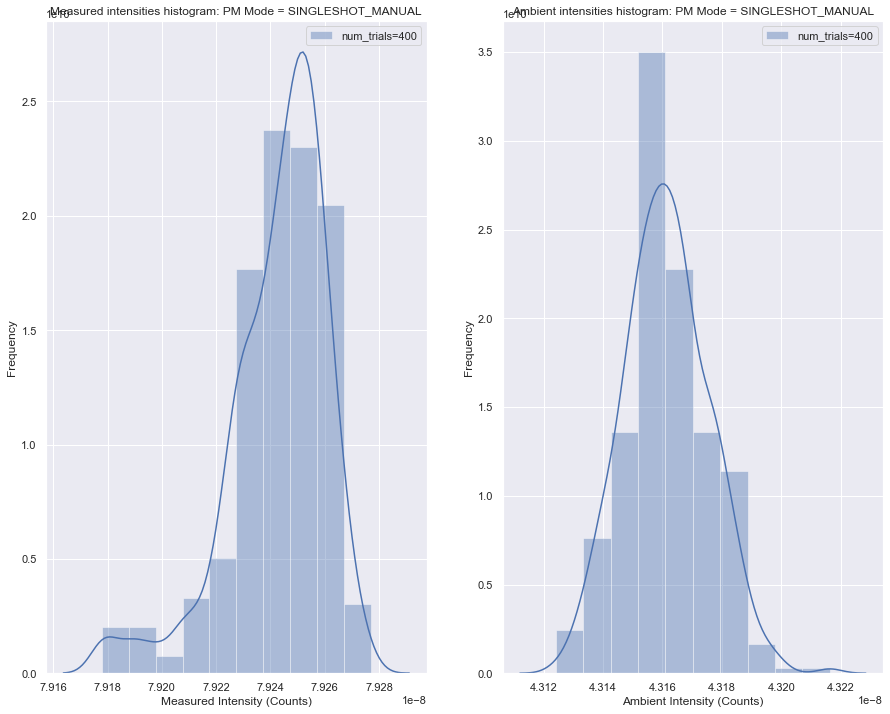

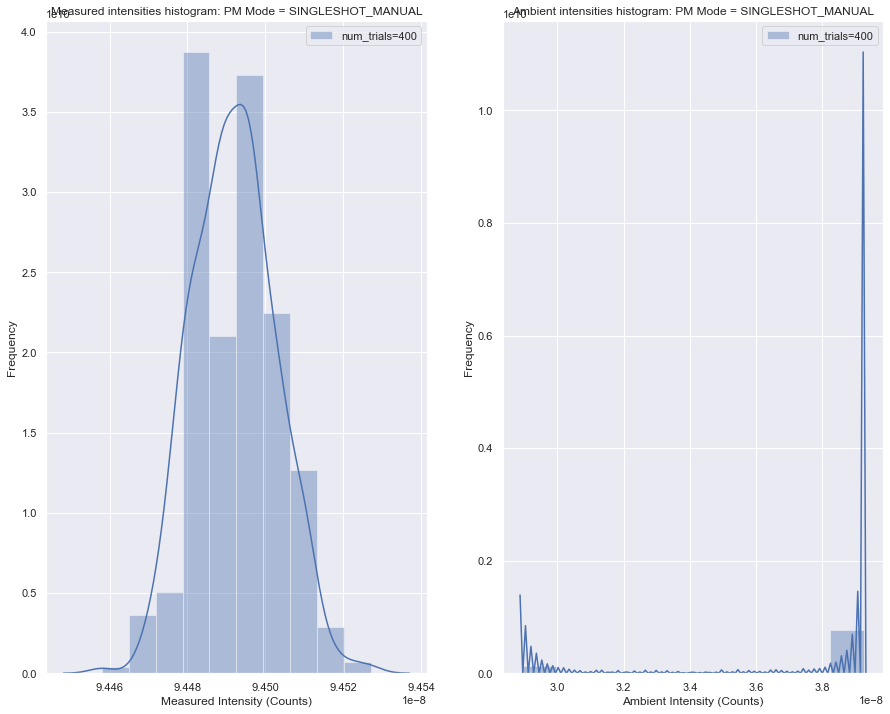

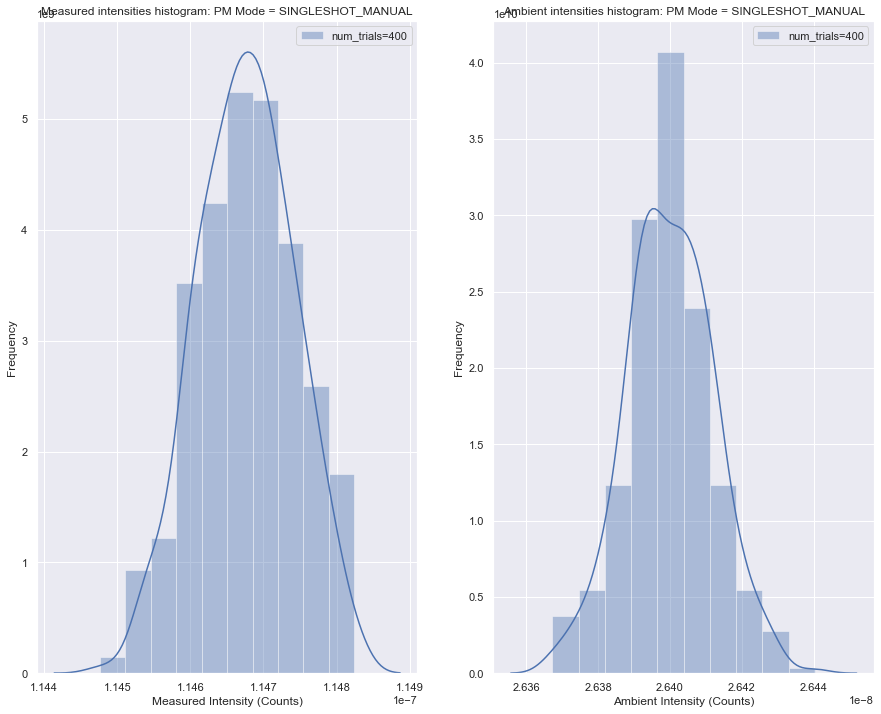

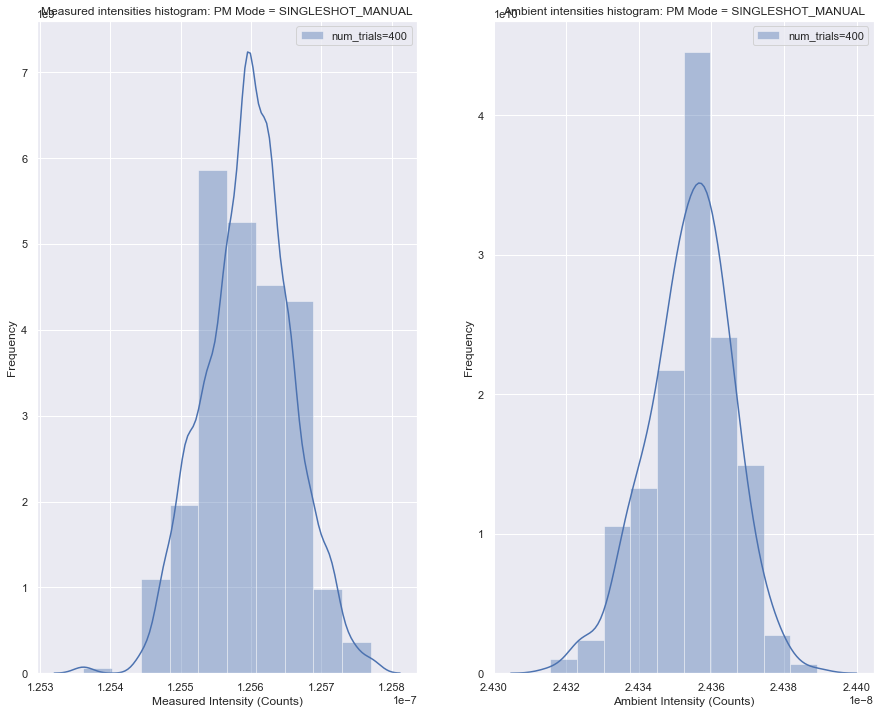

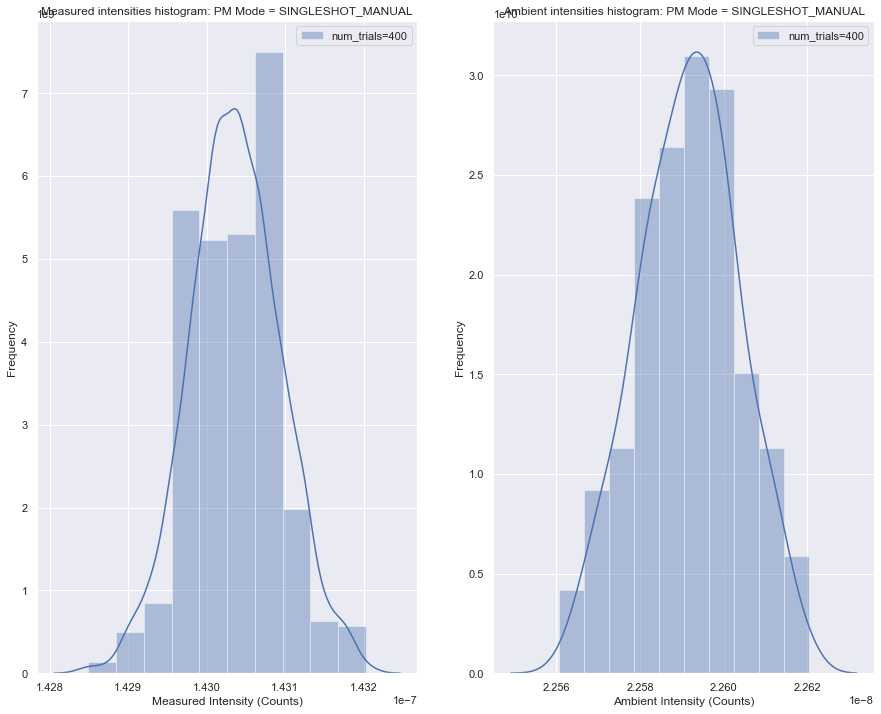

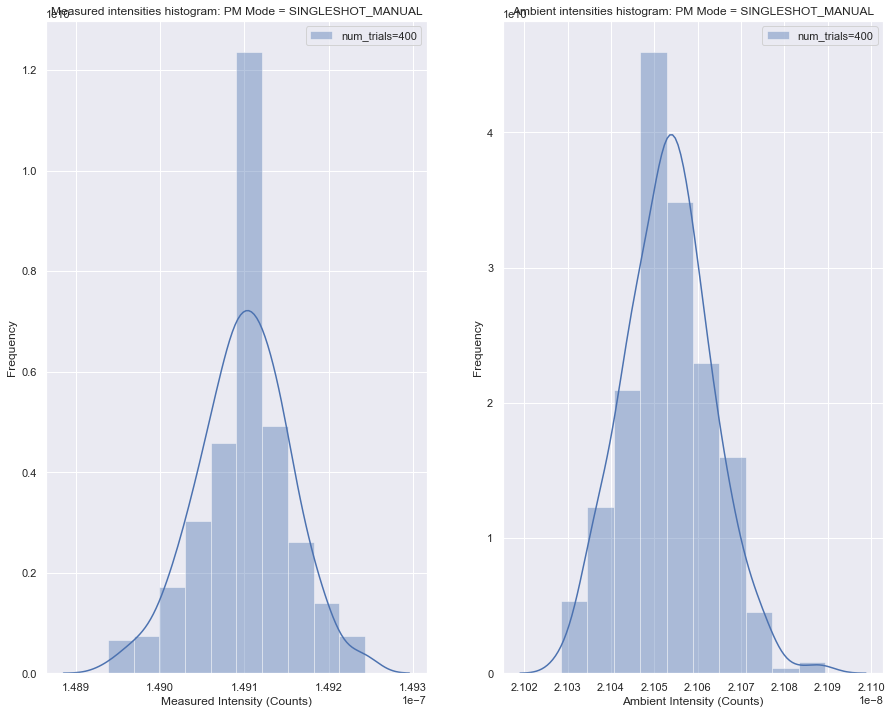

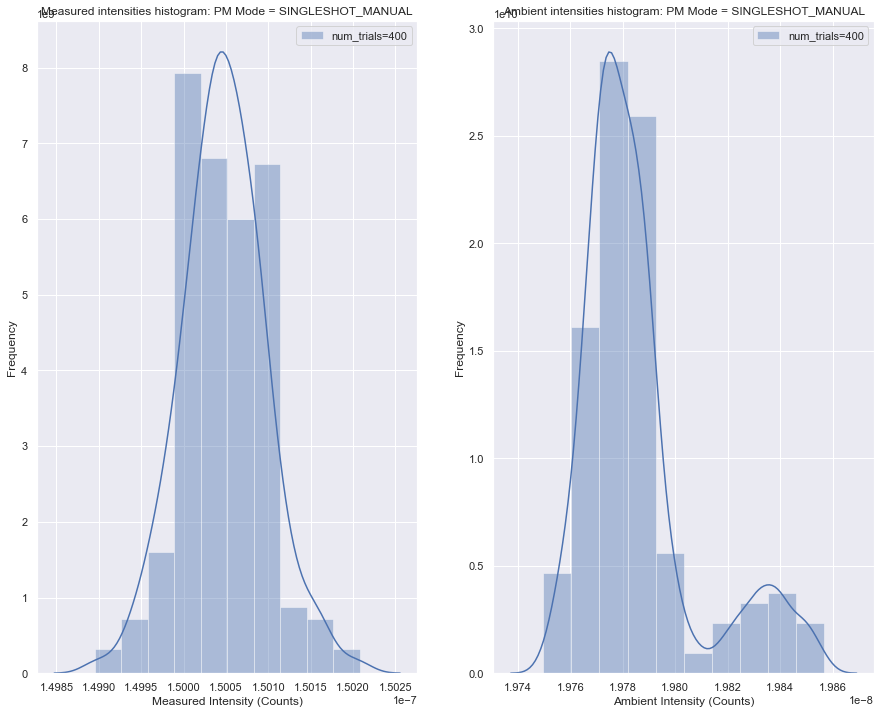

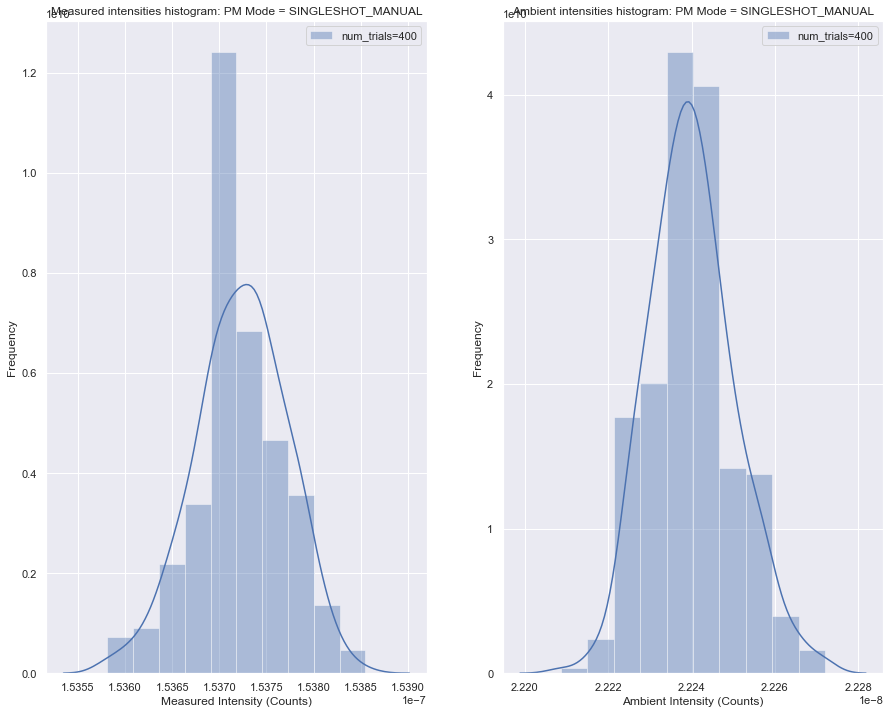

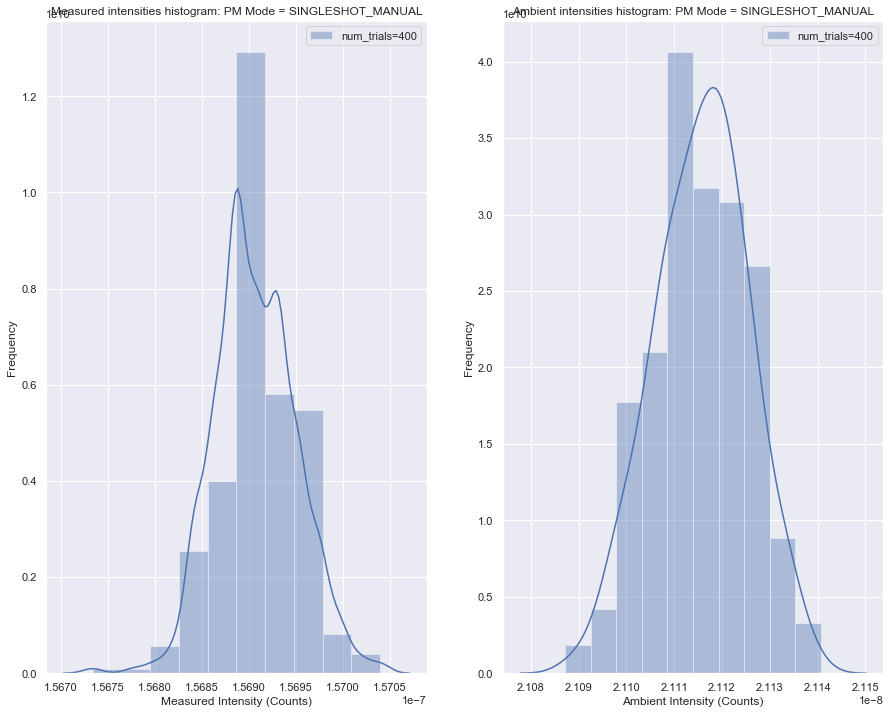

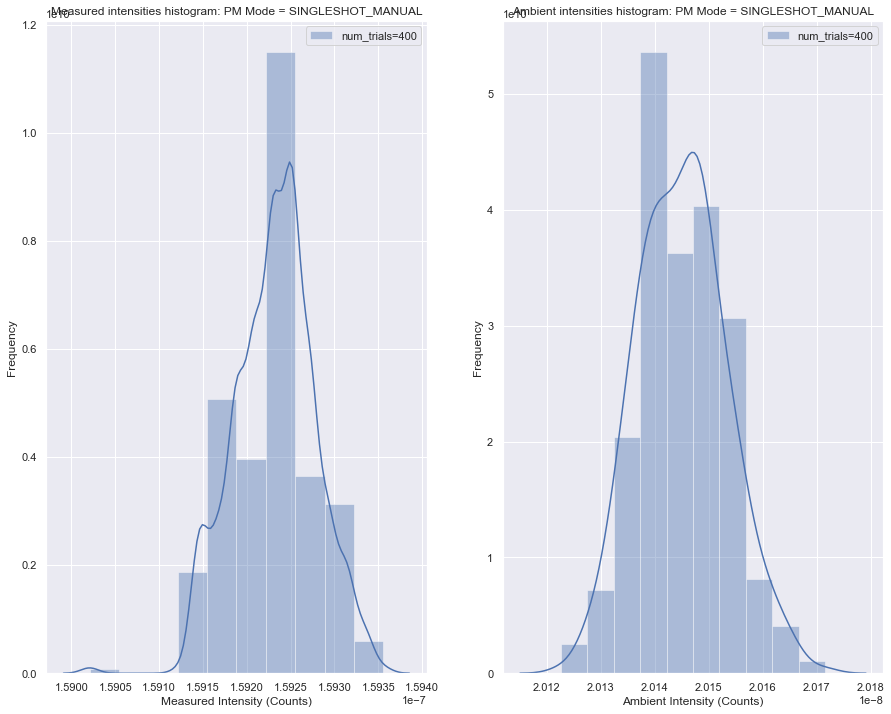

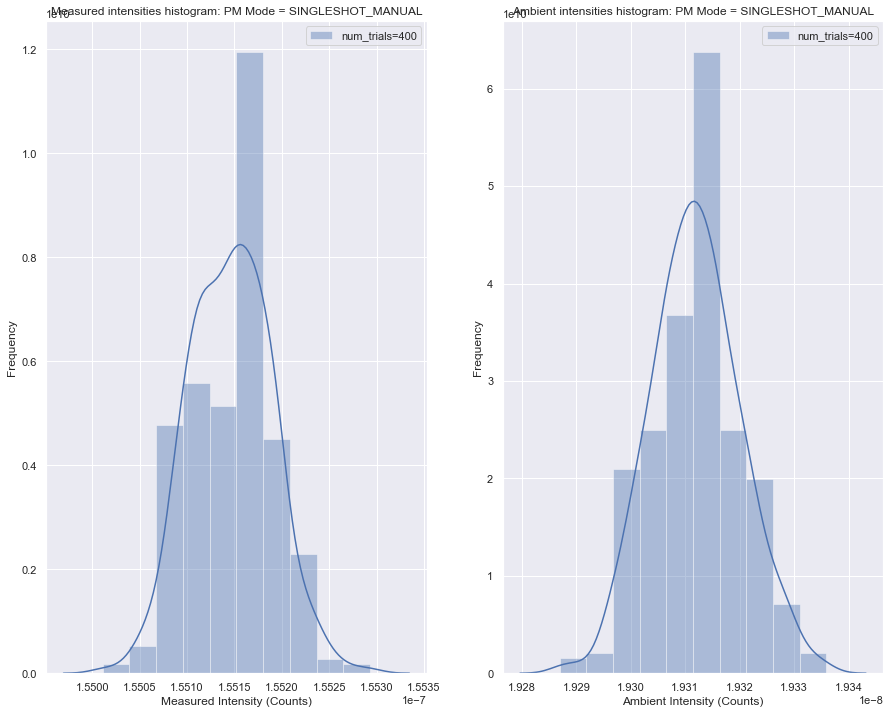

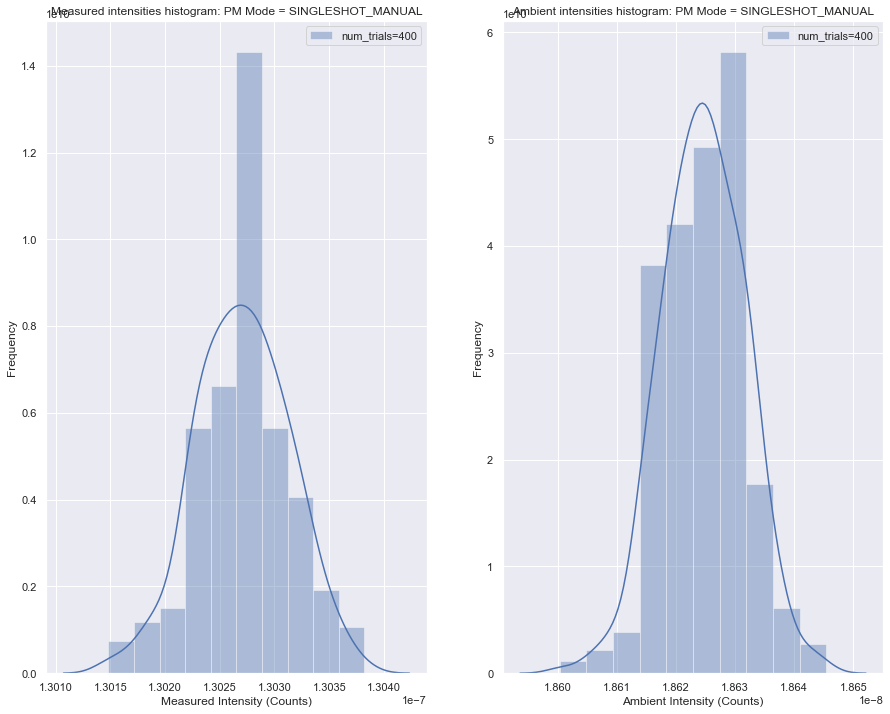

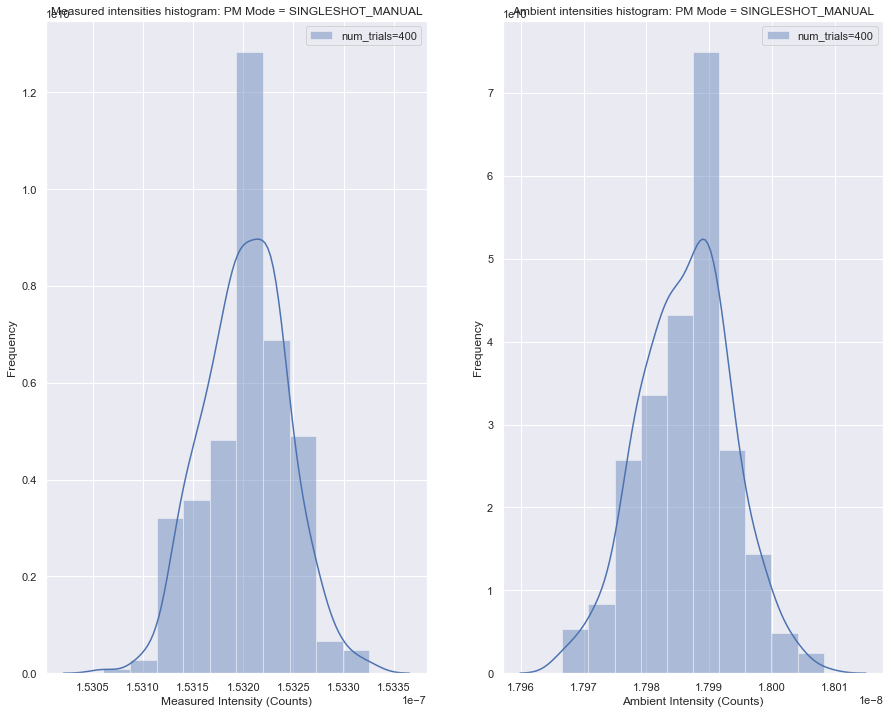

In [8]:
from calibration.powermeter import run_powermeter
run_powermeter(wls, trials)

## 2. Spectrometer

Setting the wavelength of the slow source to: 460.00
2020-02-17 22:01:49.366649 Working on trial 0
2020-02-17 22:01:49.901744 Working on trial 1
2020-02-17 22:01:50.439063 Working on trial 2
2020-02-17 22:01:50.954763 Working on trial 3
2020-02-17 22:01:51.581084 Working on trial 4
2020-02-17 22:01:52.187336 Working on trial 5
2020-02-17 22:01:52.800656 Working on trial 6
2020-02-17 22:01:53.415209 Working on trial 7
2020-02-17 22:01:53.936843 Working on trial 8
2020-02-17 22:01:54.534533 Working on trial 9
2020-02-17 22:01:55.152307 Working on trial 10
2020-02-17 22:01:55.777652 Working on trial 11
2020-02-17 22:01:56.393013 Working on trial 12
2020-02-17 22:01:57.076854 Working on trial 13
2020-02-17 22:01:57.600516 Working on trial 14
2020-02-17 22:01:58.121274 Working on trial 15
2020-02-17 22:01:58.740055 Working on trial 16
2020-02-17 22:01:59.357754 Working on trial 17
2020-02-17 22:01:59.879760 Working on trial 18
2020-02-17 22:02:00.472157 Working on trial 19
2020-02-17 22:02:

2020-02-17 22:03:29.766370 Working on trial 172
2020-02-17 22:03:30.382407 Working on trial 173
2020-02-17 22:03:31.000783 Working on trial 174
2020-02-17 22:03:31.511892 Working on trial 175
2020-02-17 22:03:32.117757 Working on trial 176
2020-02-17 22:03:32.731665 Working on trial 177
2020-02-17 22:03:33.359723 Working on trial 178
2020-02-17 22:03:33.953389 Working on trial 179
2020-02-17 22:03:34.487085 Working on trial 180
2020-02-17 22:03:35.086854 Working on trial 181
2020-02-17 22:03:35.709854 Working on trial 182
2020-02-17 22:03:36.317337 Working on trial 183
2020-02-17 22:03:36.830779 Working on trial 184
2020-02-17 22:03:37.448520 Working on trial 185
2020-02-17 22:03:38.063710 Working on trial 186
2020-02-17 22:03:38.680395 Working on trial 187
2020-02-17 22:03:39.300669 Working on trial 188
2020-02-17 22:03:39.903320 Working on trial 189
2020-02-17 22:03:40.521543 Working on trial 190
2020-02-17 22:03:41.133722 Working on trial 191
2020-02-17 22:03:41.753556 Working on tr

2020-02-17 22:05:15.136848 Working on trial 343
2020-02-17 22:05:15.730799 Working on trial 344
2020-02-17 22:05:16.342715 Working on trial 345
2020-02-17 22:05:16.959165 Working on trial 346
2020-02-17 22:05:17.577345 Working on trial 347
2020-02-17 22:05:18.081230 Working on trial 348
2020-02-17 22:05:18.584502 Working on trial 349
2020-02-17 22:05:19.088696 Working on trial 350
2020-02-17 22:05:19.597172 Working on trial 351
2020-02-17 22:05:20.095139 Working on trial 352
2020-02-17 22:05:20.644528 Working on trial 353
2020-02-17 22:05:21.151101 Working on trial 354
2020-02-17 22:05:21.657331 Working on trial 355
2020-02-17 22:05:22.172435 Working on trial 356
2020-02-17 22:05:22.668101 Working on trial 357
2020-02-17 22:05:23.188592 Working on trial 358
2020-02-17 22:05:23.703517 Working on trial 359
2020-02-17 22:05:24.214448 Working on trial 360
2020-02-17 22:05:24.729308 Working on trial 361
2020-02-17 22:05:25.228152 Working on trial 362
2020-02-17 22:05:25.734483 Working on tr

2020-02-17 22:07:03.437357 Working on trial 115
2020-02-17 22:07:03.945102 Working on trial 116
2020-02-17 22:07:04.458034 Working on trial 117
2020-02-17 22:07:04.974569 Working on trial 118
2020-02-17 22:07:05.488236 Working on trial 119
2020-02-17 22:07:05.987893 Working on trial 120
2020-02-17 22:07:06.522529 Working on trial 121
2020-02-17 22:07:07.031454 Working on trial 122
2020-02-17 22:07:07.533111 Working on trial 123
2020-02-17 22:07:08.057808 Working on trial 124
2020-02-17 22:07:08.668061 Working on trial 125
2020-02-17 22:07:09.166201 Working on trial 126
2020-02-17 22:07:09.686240 Working on trial 127
2020-02-17 22:07:10.209264 Working on trial 128
2020-02-17 22:07:10.830239 Working on trial 129
2020-02-17 22:07:11.435575 Working on trial 130
2020-02-17 22:07:12.047209 Working on trial 131
2020-02-17 22:07:12.553249 Working on trial 132
2020-02-17 22:07:13.054445 Working on trial 133
2020-02-17 22:07:13.578307 Working on trial 134
2020-02-17 22:07:14.189935 Working on tr

2020-02-17 22:09:05.922871 Working on trial 286
2020-02-17 22:09:06.530556 Working on trial 287
2020-02-17 22:09:07.139396 Working on trial 288
2020-02-17 22:09:07.757664 Working on trial 289
2020-02-17 22:09:08.374075 Working on trial 290
2020-02-17 22:09:08.884416 Working on trial 291
2020-02-17 22:09:09.485988 Working on trial 292
2020-02-17 22:09:10.010280 Working on trial 293
2020-02-17 22:09:10.629705 Working on trial 294
2020-02-17 22:09:11.244914 Working on trial 295
2020-02-17 22:09:11.853589 Working on trial 296
2020-02-17 22:09:12.350399 Working on trial 297
2020-02-17 22:09:12.873023 Working on trial 298
2020-02-17 22:09:13.502211 Working on trial 299
2020-02-17 22:09:14.098343 Working on trial 300
2020-02-17 22:09:14.610914 Working on trial 301
2020-02-17 22:09:15.119912 Working on trial 302
2020-02-17 22:09:15.628575 Working on trial 303
2020-02-17 22:09:16.149518 Working on trial 304
2020-02-17 22:09:16.666709 Working on trial 305
2020-02-17 22:09:17.286433 Working on tr

2020-02-17 22:10:55.858305 Working on trial 57
2020-02-17 22:10:56.362141 Working on trial 58
2020-02-17 22:10:56.910747 Working on trial 59
2020-02-17 22:10:57.422907 Working on trial 60
2020-02-17 22:10:57.932694 Working on trial 61
2020-02-17 22:10:58.559942 Working on trial 62
2020-02-17 22:10:59.166623 Working on trial 63
2020-02-17 22:10:59.677445 Working on trial 64
2020-02-17 22:11:00.300767 Working on trial 65
2020-02-17 22:11:00.915482 Working on trial 66
2020-02-17 22:11:01.428662 Working on trial 67
2020-02-17 22:11:01.945704 Working on trial 68
2020-02-17 22:11:02.448914 Working on trial 69
2020-02-17 22:11:03.053716 Working on trial 70
2020-02-17 22:11:03.669829 Working on trial 71
2020-02-17 22:11:04.174398 Working on trial 72
2020-02-17 22:11:04.683229 Working on trial 73
2020-02-17 22:11:05.198536 Working on trial 74
2020-02-17 22:11:05.710017 Working on trial 75
2020-02-17 22:11:06.232763 Working on trial 76
2020-02-17 22:11:08.135848 Working on trial 77
2020-02-17 22

2020-02-17 22:12:33.798855 Working on trial 229
2020-02-17 22:12:34.310052 Working on trial 230
2020-02-17 22:12:34.822335 Working on trial 231
2020-02-17 22:12:35.323895 Working on trial 232
2020-02-17 22:12:35.827661 Working on trial 233
2020-02-17 22:12:36.343182 Working on trial 234
2020-02-17 22:12:36.853314 Working on trial 235
2020-02-17 22:12:37.465860 Working on trial 236
2020-02-17 22:12:38.082660 Working on trial 237
2020-02-17 22:12:38.703883 Working on trial 238
2020-02-17 22:12:39.209298 Working on trial 239
2020-02-17 22:12:39.934629 Working on trial 240
2020-02-17 22:12:40.542768 Working on trial 241
2020-02-17 22:12:41.157660 Working on trial 242
2020-02-17 22:12:41.772985 Working on trial 243
2020-02-17 22:12:42.391898 Working on trial 244
2020-02-17 22:12:42.995836 Working on trial 245
2020-02-17 22:12:43.618869 Working on trial 246
2020-02-17 22:12:44.137606 Working on trial 247
2020-02-17 22:12:44.729710 Working on trial 248
2020-02-17 22:12:45.250070 Working on tr

Setting the wavelength of the slow source to: 520.00
2020-02-17 22:14:21.068796 Working on trial 0
2020-02-17 22:14:21.602746 Working on trial 1
2020-02-17 22:14:22.112274 Working on trial 2
2020-02-17 22:14:22.626166 Working on trial 3
2020-02-17 22:14:23.138800 Working on trial 4
2020-02-17 22:14:23.656949 Working on trial 5
2020-02-17 22:14:24.276485 Working on trial 6
2020-02-17 22:14:24.880206 Working on trial 7
2020-02-17 22:14:25.403065 Working on trial 8
2020-02-17 22:14:25.957659 Working on trial 9
2020-02-17 22:14:26.534221 Working on trial 10
2020-02-17 22:14:27.050414 Working on trial 11
2020-02-17 22:14:27.649290 Working on trial 12
2020-02-17 22:14:28.264687 Working on trial 13
2020-02-17 22:14:28.881521 Working on trial 14
2020-02-17 22:14:29.491779 Working on trial 15
2020-02-17 22:14:30.106281 Working on trial 16
2020-02-17 22:14:30.723080 Working on trial 17
2020-02-17 22:14:31.345576 Working on trial 18
2020-02-17 22:14:31.866920 Working on trial 19
2020-02-17 22:14:

2020-02-17 22:16:00.521092 Working on trial 172
2020-02-17 22:16:01.138619 Working on trial 173
2020-02-17 22:16:01.759570 Working on trial 174
2020-02-17 22:16:02.367778 Working on trial 175
2020-02-17 22:16:02.980387 Working on trial 176
2020-02-17 22:16:03.593219 Working on trial 177
2020-02-17 22:16:04.210736 Working on trial 178
2020-02-17 22:16:04.719349 Working on trial 179
2020-02-17 22:16:05.218743 Working on trial 180
2020-02-17 22:16:05.743437 Working on trial 181
2020-02-17 22:16:06.356013 Working on trial 182
2020-02-17 22:16:10.516962 Working on trial 183
2020-02-17 22:16:11.018735 Working on trial 184
2020-02-17 22:16:11.579481 Working on trial 185
2020-02-17 22:16:12.191418 Working on trial 186
2020-02-17 22:16:12.691229 Working on trial 187
2020-02-17 22:16:13.231033 Working on trial 188
2020-02-17 22:16:13.844248 Working on trial 189
2020-02-17 22:16:14.449611 Working on trial 190
2020-02-17 22:16:14.969096 Working on trial 191
2020-02-17 22:16:15.588382 Working on tr

2020-02-17 22:17:40.872394 Working on trial 343
2020-02-17 22:17:41.493888 Working on trial 344
2020-02-17 22:17:42.005270 Working on trial 345
2020-02-17 22:17:42.517086 Working on trial 346
2020-02-17 22:17:43.029833 Working on trial 347
2020-02-17 22:17:43.536146 Working on trial 348
2020-02-17 22:17:44.053959 Working on trial 349
2020-02-17 22:17:44.620603 Working on trial 350
2020-02-17 22:17:45.183617 Working on trial 351
2020-02-17 22:17:45.688334 Working on trial 352
2020-02-17 22:17:46.297431 Working on trial 353
2020-02-17 22:17:46.807958 Working on trial 354
2020-02-17 22:17:47.438430 Working on trial 355
2020-02-17 22:17:47.942697 Working on trial 356
2020-02-17 22:17:48.451558 Working on trial 357
2020-02-17 22:17:49.061651 Working on trial 358
2020-02-17 22:17:49.601398 Working on trial 359
2020-02-17 22:17:50.188163 Working on trial 360
2020-02-17 22:17:50.706718 Working on trial 361
2020-02-17 22:17:51.320637 Working on trial 362
2020-02-17 22:17:51.835355 Working on tr

2020-02-17 22:19:27.793730 Working on trial 115
2020-02-17 22:19:28.335270 Working on trial 116
2020-02-17 22:19:28.900235 Working on trial 117
2020-02-17 22:19:29.439516 Working on trial 118
2020-02-17 22:19:30.055281 Working on trial 119
2020-02-17 22:19:30.569820 Working on trial 120
2020-02-17 22:19:31.155278 Working on trial 121
2020-02-17 22:19:31.781152 Working on trial 122
2020-02-17 22:19:32.391910 Working on trial 123
2020-02-17 22:19:33.044886 Working on trial 124
2020-02-17 22:19:33.569055 Working on trial 125
2020-02-17 22:19:34.135433 Working on trial 126
2020-02-17 22:19:34.646369 Working on trial 127
2020-02-17 22:19:35.158819 Working on trial 128
2020-02-17 22:19:35.762626 Working on trial 129
2020-02-17 22:19:36.379806 Working on trial 130
2020-02-17 22:19:36.886975 Working on trial 131
2020-02-17 22:19:37.392194 Working on trial 132
2020-02-17 22:19:37.895443 Working on trial 133
2020-02-17 22:19:38.427599 Working on trial 134
2020-02-17 22:19:39.042489 Working on tr

2020-02-17 22:22:08.750137 Working on trial 286
2020-02-17 22:22:09.366963 Working on trial 287
2020-02-17 22:22:09.879875 Working on trial 288
2020-02-17 22:22:10.387079 Working on trial 289
2020-02-17 22:22:11.002293 Working on trial 290
2020-02-17 22:22:11.622198 Working on trial 291
2020-02-17 22:22:12.227254 Working on trial 292
2020-02-17 22:22:12.739817 Working on trial 293
2020-02-17 22:22:13.353286 Working on trial 294
2020-02-17 22:22:13.853120 Working on trial 295
2020-02-17 22:22:14.373247 Working on trial 296
2020-02-17 22:22:14.887859 Working on trial 297
2020-02-17 22:22:15.531124 Working on trial 298
2020-02-17 22:22:16.121122 Working on trial 299
2020-02-17 22:22:16.745318 Working on trial 300
2020-02-17 22:22:17.360815 Working on trial 301
2020-02-17 22:22:17.861760 Working on trial 302
2020-02-17 22:22:18.470493 Working on trial 303
2020-02-17 22:22:18.994486 Working on trial 304
2020-02-17 22:22:19.612229 Working on trial 305
2020-02-17 22:22:20.326873 Working on tr

2020-02-17 22:23:59.145862 Working on trial 57
2020-02-17 22:23:59.954485 Working on trial 58
2020-02-17 22:24:00.572813 Working on trial 59
2020-02-17 22:24:01.193582 Working on trial 60
2020-02-17 22:24:01.811198 Working on trial 61
2020-02-17 22:24:02.429167 Working on trial 62
2020-02-17 22:24:03.032226 Working on trial 63
2020-02-17 22:24:03.638516 Working on trial 64
2020-02-17 22:24:04.232800 Working on trial 65
2020-02-17 22:24:04.778055 Working on trial 66
2020-02-17 22:24:05.380616 Working on trial 67
2020-02-17 22:24:06.153143 Working on trial 68
2020-02-17 22:24:06.725576 Working on trial 69
2020-02-17 22:24:07.334631 Working on trial 70
2020-02-17 22:24:07.850134 Working on trial 71
2020-02-17 22:24:08.365736 Working on trial 72
2020-02-17 22:24:08.973407 Working on trial 73
2020-02-17 22:24:09.488654 Working on trial 74
2020-02-17 22:24:10.007231 Working on trial 75
2020-02-17 22:24:10.613917 Working on trial 76
2020-02-17 22:24:11.221281 Working on trial 77
2020-02-17 22

2020-02-17 22:25:39.302883 Working on trial 229
2020-02-17 22:25:40.090999 Working on trial 230
2020-02-17 22:25:40.612478 Working on trial 231
2020-02-17 22:25:41.127672 Working on trial 232
2020-02-17 22:25:41.744636 Working on trial 233
2020-02-17 22:25:42.251448 Working on trial 234
2020-02-17 22:25:42.765030 Working on trial 235
2020-02-17 22:25:43.379765 Working on trial 236
2020-02-17 22:25:43.890815 Working on trial 237
2020-02-17 22:25:44.499262 Working on trial 238
2020-02-17 22:25:45.016182 Working on trial 239
2020-02-17 22:25:45.550062 Working on trial 240
2020-02-17 22:25:46.069930 Working on trial 241
2020-02-17 22:25:46.581973 Working on trial 242
2020-02-17 22:25:47.086194 Working on trial 243
2020-02-17 22:25:47.687427 Working on trial 244
2020-02-17 22:25:48.192676 Working on trial 245
2020-02-17 22:25:48.804295 Working on trial 246
2020-02-17 22:25:49.311965 Working on trial 247
2020-02-17 22:25:49.827585 Working on trial 248
2020-02-17 22:25:50.347346 Working on tr

Setting the wavelength of the slow source to: 580.00
2020-02-17 22:27:32.480171 Working on trial 0
2020-02-17 22:27:33.044729 Working on trial 1
2020-02-17 22:27:33.654401 Working on trial 2
2020-02-17 22:27:34.155073 Working on trial 3
2020-02-17 22:27:34.678626 Working on trial 4
2020-02-17 22:27:35.190495 Working on trial 5
2020-02-17 22:27:35.700338 Working on trial 6
2020-02-17 22:27:36.200075 Working on trial 7
2020-02-17 22:27:36.726621 Working on trial 8
2020-02-17 22:27:37.346132 Working on trial 9
2020-02-17 22:27:37.848373 Working on trial 10
2020-02-17 22:27:38.366549 Working on trial 11
2020-02-17 22:27:38.979334 Working on trial 12
2020-02-17 22:27:39.482203 Working on trial 13
2020-02-17 22:27:40.003121 Working on trial 14
2020-02-17 22:27:40.514748 Working on trial 15
2020-02-17 22:27:41.026612 Working on trial 16
2020-02-17 22:27:41.536774 Working on trial 17
2020-02-17 22:27:42.040166 Working on trial 18
2020-02-17 22:27:42.542893 Working on trial 19
2020-02-17 22:27:

2020-02-17 22:29:08.173837 Working on trial 172
2020-02-17 22:29:08.823391 Working on trial 173
2020-02-17 22:29:09.437969 Working on trial 174
2020-02-17 22:29:10.036503 Working on trial 175
2020-02-17 22:29:10.543660 Working on trial 176
2020-02-17 22:29:11.141908 Working on trial 177
2020-02-17 22:29:11.759972 Working on trial 178
2020-02-17 22:29:12.376191 Working on trial 179
2020-02-17 22:29:12.884602 Working on trial 180
2020-02-17 22:29:13.496525 Working on trial 181
2020-02-17 22:29:14.114265 Working on trial 182
2020-02-17 22:29:14.737165 Working on trial 183
2020-02-17 22:29:15.347246 Working on trial 184
2020-02-17 22:29:15.859282 Working on trial 185
2020-02-17 22:29:16.472040 Working on trial 186
2020-02-17 22:29:17.137732 Working on trial 187
2020-02-17 22:29:17.704009 Working on trial 188
2020-02-17 22:29:18.242256 Working on trial 189
2020-02-17 22:29:18.860663 Working on trial 190
2020-02-17 22:29:19.388426 Working on trial 191
2020-02-17 22:29:19.912905 Working on tr

2020-02-17 22:30:47.120051 Working on trial 343
2020-02-17 22:30:47.692849 Working on trial 344
2020-02-17 22:30:48.240335 Working on trial 345
2020-02-17 22:30:48.870437 Working on trial 346
2020-02-17 22:30:49.517873 Working on trial 347
2020-02-17 22:30:50.187673 Working on trial 348
2020-02-17 22:30:50.783601 Working on trial 349
2020-02-17 22:30:51.340657 Working on trial 350
2020-02-17 22:30:51.904889 Working on trial 351
2020-02-17 22:30:52.552534 Working on trial 352
2020-02-17 22:30:53.069881 Working on trial 353
2020-02-17 22:30:53.571387 Working on trial 354
2020-02-17 22:30:54.096795 Working on trial 355
2020-02-17 22:30:54.643372 Working on trial 356
2020-02-17 22:30:55.156724 Working on trial 357
2020-02-17 22:30:55.667850 Working on trial 358
2020-02-17 22:30:56.213867 Working on trial 359
2020-02-17 22:30:56.731093 Working on trial 360
2020-02-17 22:30:57.247445 Working on trial 361
2020-02-17 22:30:57.776580 Working on trial 362
2020-02-17 22:30:58.315871 Working on tr

2020-02-17 22:32:35.941849 Working on trial 115
2020-02-17 22:32:36.558447 Working on trial 116
2020-02-17 22:32:37.153937 Working on trial 117
2020-02-17 22:32:37.688552 Working on trial 118
2020-02-17 22:32:38.305762 Working on trial 119
2020-02-17 22:32:38.909733 Working on trial 120
2020-02-17 22:32:39.508389 Working on trial 121
2020-02-17 22:32:40.043126 Working on trial 122
2020-02-17 22:32:40.650562 Working on trial 123
2020-02-17 22:32:41.269794 Working on trial 124
2020-02-17 22:32:41.779562 Working on trial 125
2020-02-17 22:32:42.397554 Working on trial 126
2020-02-17 22:32:42.910940 Working on trial 127
2020-02-17 22:32:43.528356 Working on trial 128
2020-02-17 22:32:44.139387 Working on trial 129
2020-02-17 22:32:44.646206 Working on trial 130
2020-02-17 22:32:45.165484 Working on trial 131
2020-02-17 22:32:45.780590 Working on trial 132
2020-02-17 22:32:46.388371 Working on trial 133
2020-02-17 22:32:47.010566 Working on trial 134
2020-02-17 22:32:47.524352 Working on tr

2020-02-17 22:34:14.034594 Working on trial 286
2020-02-17 22:34:14.658420 Working on trial 287
2020-02-17 22:34:15.162972 Working on trial 288
2020-02-17 22:34:15.783806 Working on trial 289
2020-02-17 22:34:16.391291 Working on trial 290
2020-02-17 22:34:17.005394 Working on trial 291
2020-02-17 22:34:17.509878 Working on trial 292
2020-02-17 22:34:18.025452 Working on trial 293
2020-02-17 22:34:18.532610 Working on trial 294
2020-02-17 22:34:19.049817 Working on trial 295
2020-02-17 22:34:19.563835 Working on trial 296
2020-02-17 22:34:20.391343 Working on trial 297
2020-02-17 22:34:20.992448 Working on trial 298
2020-02-17 22:34:21.510311 Working on trial 299
2020-02-17 22:34:22.120780 Working on trial 300
2020-02-17 22:34:22.633885 Working on trial 301
2020-02-17 22:34:23.136692 Working on trial 302
2020-02-17 22:34:23.655810 Working on trial 303
2020-02-17 22:34:24.168702 Working on trial 304
2020-02-17 22:34:24.680111 Working on trial 305
2020-02-17 22:34:25.194124 Working on tr

2020-02-17 22:36:01.865850 Working on trial 57
2020-02-17 22:36:02.485043 Working on trial 58
2020-02-17 22:36:03.088472 Working on trial 59
2020-02-17 22:36:03.601488 Working on trial 60
2020-02-17 22:36:04.113560 Working on trial 61
2020-02-17 22:36:04.740487 Working on trial 62
2020-02-17 22:36:05.251817 Working on trial 63
2020-02-17 22:36:05.762936 Working on trial 64
2020-02-17 22:36:06.353197 Working on trial 65
2020-02-17 22:36:06.871271 Working on trial 66
2020-02-17 22:36:07.394569 Working on trial 67
2020-02-17 22:36:07.913515 Working on trial 68
2020-02-17 22:36:08.521733 Working on trial 69
2020-02-17 22:36:09.144507 Working on trial 70
2020-02-17 22:36:09.657746 Working on trial 71
2020-02-17 22:36:10.266573 Working on trial 72
2020-02-17 22:36:10.782336 Working on trial 73
2020-02-17 22:36:11.393341 Working on trial 74
2020-02-17 22:36:11.912646 Working on trial 75
2020-02-17 22:36:12.506832 Working on trial 76
2020-02-17 22:36:13.046347 Working on trial 77
2020-02-17 22

2020-02-17 22:37:38.624577 Working on trial 229
2020-02-17 22:37:39.240641 Working on trial 230
2020-02-17 22:37:39.858313 Working on trial 231
2020-02-17 22:37:40.472240 Working on trial 232
2020-02-17 22:37:41.086000 Working on trial 233
2020-02-17 22:37:41.699585 Working on trial 234
2020-02-17 22:37:42.206826 Working on trial 235
2020-02-17 22:37:42.707026 Working on trial 236
2020-02-17 22:37:43.233994 Working on trial 237
2020-02-17 22:37:43.852326 Working on trial 238
2020-02-17 22:37:44.465842 Working on trial 239
2020-02-17 22:37:44.967752 Working on trial 240
2020-02-17 22:37:45.499424 Working on trial 241
2020-02-17 22:37:46.000156 Working on trial 242
2020-02-17 22:37:46.612562 Working on trial 243
2020-02-17 22:37:47.116270 Working on trial 244
2020-02-17 22:37:47.639370 Working on trial 245
2020-02-17 22:37:48.250273 Working on trial 246
2020-02-17 22:37:48.771643 Working on trial 247
2020-02-17 22:37:49.276287 Working on trial 248
2020-02-17 22:37:49.789750 Working on tr

Setting the wavelength of the slow source to: 640.00
2020-02-17 22:39:26.295289 Working on trial 0
2020-02-17 22:39:26.862389 Working on trial 1
2020-02-17 22:39:27.479311 Working on trial 2
2020-02-17 22:39:28.090554 Working on trial 3
2020-02-17 22:39:28.604238 Working on trial 4
2020-02-17 22:39:29.115999 Working on trial 5
2020-02-17 22:39:29.729906 Working on trial 6
2020-02-17 22:39:30.240192 Working on trial 7
2020-02-17 22:39:30.756211 Working on trial 8
2020-02-17 22:39:31.263616 Working on trial 9
2020-02-17 22:39:31.778113 Working on trial 10
2020-02-17 22:39:32.393530 Working on trial 11
2020-02-17 22:39:33.009275 Working on trial 12
2020-02-17 22:39:33.620833 Working on trial 13
2020-02-17 22:39:34.246780 Working on trial 14
2020-02-17 22:39:34.754540 Working on trial 15
2020-02-17 22:39:35.362875 Working on trial 16
2020-02-17 22:39:37.838233 Working on trial 17
2020-02-17 22:39:38.429454 Working on trial 18
2020-02-17 22:39:38.930395 Working on trial 19
2020-02-17 22:39:

2020-02-17 22:41:22.117660 Working on trial 172
2020-02-17 22:41:22.761422 Working on trial 173
2020-02-17 22:41:23.343178 Working on trial 174
2020-02-17 22:41:23.963691 Working on trial 175
2020-02-17 22:41:24.479490 Working on trial 176
2020-02-17 22:41:25.077174 Working on trial 177
2020-02-17 22:41:25.704226 Working on trial 178
2020-02-17 22:41:26.316502 Working on trial 179
2020-02-17 22:41:26.936777 Working on trial 180
2020-02-17 22:41:27.547885 Working on trial 181
2020-02-17 22:41:28.165326 Working on trial 182
2020-02-17 22:41:28.759945 Working on trial 183
2020-02-17 22:41:29.382358 Working on trial 184
2020-02-17 22:41:30.014022 Working on trial 185
2020-02-17 22:41:30.532691 Working on trial 186
2020-02-17 22:41:31.129148 Working on trial 187
2020-02-17 22:41:31.740410 Working on trial 188
2020-02-17 22:41:32.353331 Working on trial 189
2020-02-17 22:41:32.864735 Working on trial 190
2020-02-17 22:41:33.469046 Working on trial 191
2020-02-17 22:41:34.094840 Working on tr

2020-02-17 22:43:03.808405 Working on trial 343
2020-02-17 22:43:04.424931 Working on trial 344
2020-02-17 22:43:05.026324 Working on trial 345
2020-02-17 22:43:05.643845 Working on trial 346
2020-02-17 22:43:06.251243 Working on trial 347
2020-02-17 22:43:06.885623 Working on trial 348
2020-02-17 22:43:07.484638 Working on trial 349
2020-02-17 22:43:08.104269 Working on trial 350
2020-02-17 22:43:08.651875 Working on trial 351
2020-02-17 22:43:09.224706 Working on trial 352
2020-02-17 22:43:09.849331 Working on trial 353
2020-02-17 22:43:10.476390 Working on trial 354
2020-02-17 22:43:11.057055 Working on trial 355
2020-02-17 22:43:11.669192 Working on trial 356
2020-02-17 22:43:12.286675 Working on trial 357
2020-02-17 22:43:12.900836 Working on trial 358
2020-02-17 22:43:13.540205 Working on trial 359
2020-02-17 22:43:14.127385 Working on trial 360
2020-02-17 22:43:14.739205 Working on trial 361
2020-02-17 22:43:15.255525 Working on trial 362
2020-02-17 22:43:15.871591 Working on tr

2020-02-17 22:44:58.984338 Working on trial 115
2020-02-17 22:44:59.625746 Working on trial 116
2020-02-17 22:45:00.220305 Working on trial 117
2020-02-17 22:45:00.829469 Working on trial 118
2020-02-17 22:45:01.443347 Working on trial 119
2020-02-17 22:45:02.058829 Working on trial 120
2020-02-17 22:45:02.692292 Working on trial 121
2020-02-17 22:45:03.298163 Working on trial 122
2020-02-17 22:45:03.943236 Working on trial 123
2020-02-17 22:45:04.522242 Working on trial 124
2020-02-17 22:45:05.130200 Working on trial 125
2020-02-17 22:45:05.767262 Working on trial 126
2020-02-17 22:45:06.358880 Working on trial 127
2020-02-17 22:45:06.981661 Working on trial 128
2020-02-17 22:45:07.594957 Working on trial 129
2020-02-17 22:45:08.206046 Working on trial 130
2020-02-17 22:45:08.819661 Working on trial 131
2020-02-17 22:45:09.436996 Working on trial 132
2020-02-17 22:45:10.045498 Working on trial 133
2020-02-17 22:45:10.655337 Working on trial 134
2020-02-17 22:45:11.276079 Working on tr

2020-02-17 22:46:41.905542 Working on trial 286
2020-02-17 22:46:42.409885 Working on trial 287
2020-02-17 22:46:43.020497 Working on trial 288
2020-02-17 22:46:43.647799 Working on trial 289
2020-02-17 22:46:44.248446 Working on trial 290
2020-02-17 22:46:44.868204 Working on trial 291
2020-02-17 22:46:45.374232 Working on trial 292
2020-02-17 22:46:45.888534 Working on trial 293
2020-02-17 22:46:46.501707 Working on trial 294
2020-02-17 22:46:47.114411 Working on trial 295
2020-02-17 22:46:47.618364 Working on trial 296
2020-02-17 22:46:48.144078 Working on trial 297
2020-02-17 22:46:48.646001 Working on trial 298
2020-02-17 22:46:49.162726 Working on trial 299
2020-02-17 22:46:49.695905 Working on trial 300
2020-02-17 22:46:50.333195 Working on trial 301
2020-02-17 22:46:50.917804 Working on trial 302
2020-02-17 22:46:51.545847 Working on trial 303
2020-02-17 22:46:52.069735 Working on trial 304
2020-02-17 22:46:52.705820 Working on trial 305
2020-02-17 22:46:53.282580 Working on tr

2020-02-17 22:48:54.807091 Working on trial 57
2020-02-17 22:48:55.423848 Working on trial 58
2020-02-17 22:48:56.037174 Working on trial 59
2020-02-17 22:48:56.654634 Working on trial 60
2020-02-17 22:48:57.275104 Working on trial 61
2020-02-17 22:48:57.889177 Working on trial 62
2020-02-17 22:48:58.506205 Working on trial 63
2020-02-17 22:48:59.117436 Working on trial 64
2020-02-17 22:48:59.725356 Working on trial 65
2020-02-17 22:49:00.340096 Working on trial 66
2020-02-17 22:49:00.853519 Working on trial 67
2020-02-17 22:49:01.464869 Working on trial 68
2020-02-17 22:49:01.977666 Working on trial 69
2020-02-17 22:49:02.487898 Working on trial 70
2020-02-17 22:49:03.109813 Working on trial 71
2020-02-17 22:49:03.623784 Working on trial 72
2020-02-17 22:49:04.234838 Working on trial 73
2020-02-17 22:49:04.843123 Working on trial 74
2020-02-17 22:49:05.470747 Working on trial 75
2020-02-17 22:49:06.084063 Working on trial 76
2020-02-17 22:49:06.687461 Working on trial 77
2020-02-17 22

2020-02-17 22:50:37.001645 Working on trial 229
2020-02-17 22:50:37.613028 Working on trial 230
2020-02-17 22:50:38.231982 Working on trial 231
2020-02-17 22:50:38.852483 Working on trial 232
2020-02-17 22:50:39.369903 Working on trial 233
2020-02-17 22:50:39.989077 Working on trial 234
2020-02-17 22:50:40.608610 Working on trial 235
2020-02-17 22:50:41.220803 Working on trial 236
2020-02-17 22:50:41.917684 Working on trial 237
2020-02-17 22:50:42.538410 Working on trial 238
2020-02-17 22:50:43.150232 Working on trial 239
2020-02-17 22:50:43.646090 Working on trial 240
2020-02-17 22:50:44.175565 Working on trial 241
2020-02-17 22:50:44.788083 Working on trial 242
2020-02-17 22:50:45.415984 Working on trial 243
2020-02-17 22:50:45.928989 Working on trial 244
2020-02-17 22:50:46.436558 Working on trial 245
2020-02-17 22:50:46.951290 Working on trial 246
2020-02-17 22:50:47.554693 Working on trial 247
2020-02-17 22:50:48.164598 Working on trial 248
2020-02-17 22:50:48.779893 Working on tr

Setting the wavelength of the slow source to: 700.00
2020-02-17 22:52:34.401424 Working on trial 0
2020-02-17 22:52:35.254815 Working on trial 1
2020-02-17 22:52:36.062908 Working on trial 2
2020-02-17 22:52:36.851091 Working on trial 3
2020-02-17 22:52:37.681113 Working on trial 4
2020-02-17 22:52:38.496780 Working on trial 5
2020-02-17 22:52:39.360026 Working on trial 6
2020-02-17 22:52:40.120087 Working on trial 7
2020-02-17 22:52:40.967404 Working on trial 8
2020-02-17 22:52:41.740697 Working on trial 9
2020-02-17 22:52:42.572250 Working on trial 10
2020-02-17 22:52:43.451626 Working on trial 11
2020-02-17 22:52:44.208750 Working on trial 12
2020-02-17 22:52:45.044884 Working on trial 13
2020-02-17 22:52:45.801864 Working on trial 14
2020-02-17 22:52:46.561120 Working on trial 15
2020-02-17 22:52:47.388248 Working on trial 16
2020-02-17 22:52:48.199051 Working on trial 17
2020-02-17 22:52:49.047911 Working on trial 18
2020-02-17 22:52:49.831769 Working on trial 19
2020-02-17 22:52:

2020-02-17 22:55:01.208475 Working on trial 172
2020-02-17 22:55:01.943843 Working on trial 173
2020-02-17 22:55:03.152470 Working on trial 174
2020-02-17 22:55:03.975343 Working on trial 175
2020-02-17 22:55:04.792293 Working on trial 176
2020-02-17 22:55:05.610815 Working on trial 177
2020-02-17 22:55:06.430549 Working on trial 178
2020-02-17 22:55:07.251519 Working on trial 179
2020-02-17 22:55:08.084238 Working on trial 180
2020-02-17 22:55:08.891807 Working on trial 181
2020-02-17 22:55:09.708904 Working on trial 182
2020-02-17 22:55:10.446274 Working on trial 183
2020-02-17 22:55:11.240756 Working on trial 184
2020-02-17 22:55:12.066442 Working on trial 185
2020-02-17 22:55:12.887664 Working on trial 186
2020-02-17 22:55:14.011307 Working on trial 187
2020-02-17 22:55:14.828737 Working on trial 188
2020-02-17 22:55:15.659545 Working on trial 189
2020-02-17 22:55:16.462128 Working on trial 190
2020-02-17 22:55:17.385694 Working on trial 191
2020-02-17 22:55:18.209237 Working on tr

2020-02-17 22:57:34.741289 Working on trial 343
2020-02-17 22:57:35.574116 Working on trial 344
2020-02-17 22:57:36.376457 Working on trial 345
2020-02-17 22:57:37.201488 Working on trial 346
2020-02-17 22:57:38.017463 Working on trial 347
2020-02-17 22:57:38.831104 Working on trial 348
2020-02-17 22:57:39.659551 Working on trial 349
2020-02-17 22:57:40.475295 Working on trial 350
2020-02-17 22:57:41.295947 Working on trial 351
2020-02-17 22:57:42.215200 Working on trial 352
2020-02-17 22:57:43.038895 Working on trial 353
2020-02-17 22:57:43.854264 Working on trial 354
2020-02-17 22:57:44.676142 Working on trial 355
2020-02-17 22:57:45.501430 Working on trial 356
2020-02-17 22:57:46.310677 Working on trial 357
2020-02-17 22:57:47.138294 Working on trial 358
2020-02-17 22:57:47.953281 Working on trial 359
2020-02-17 22:57:48.692877 Working on trial 360
2020-02-17 22:57:49.485929 Working on trial 361
2020-02-17 22:57:50.234323 Working on trial 362
2020-02-17 22:57:50.975630 Working on tr

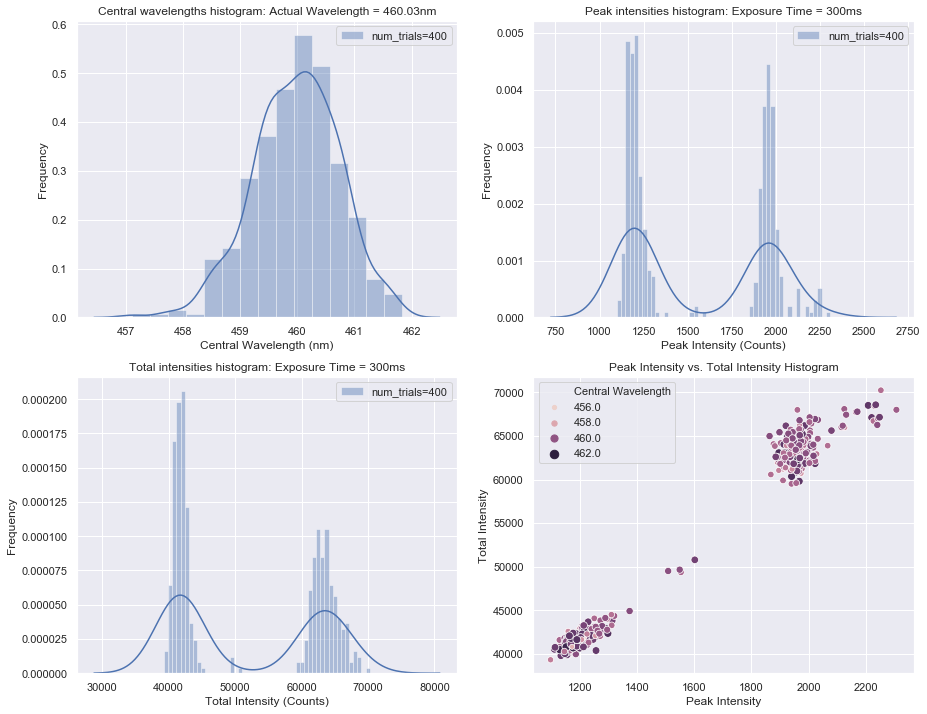

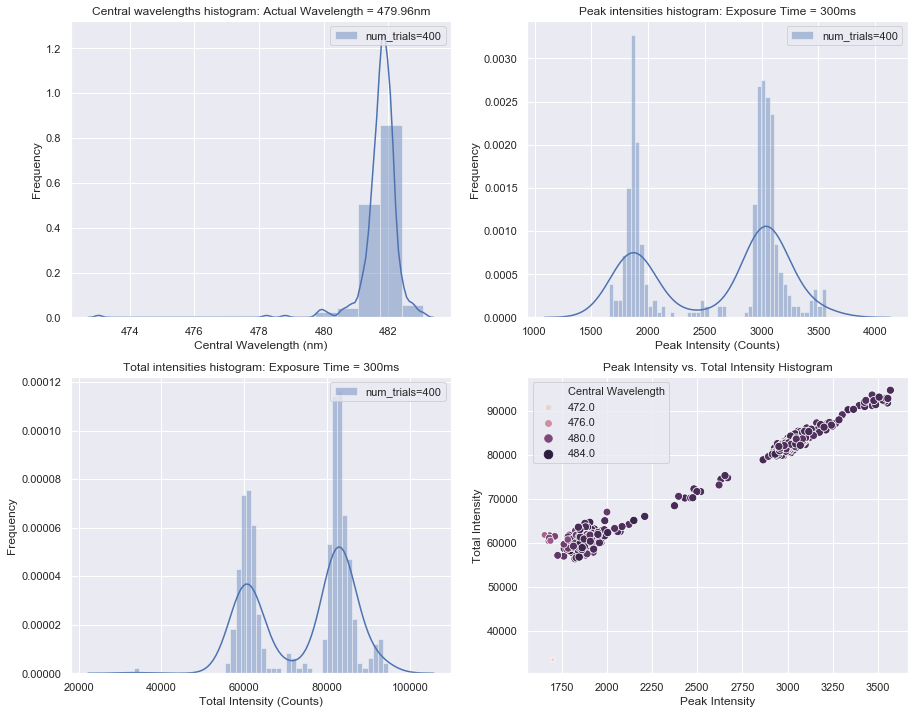

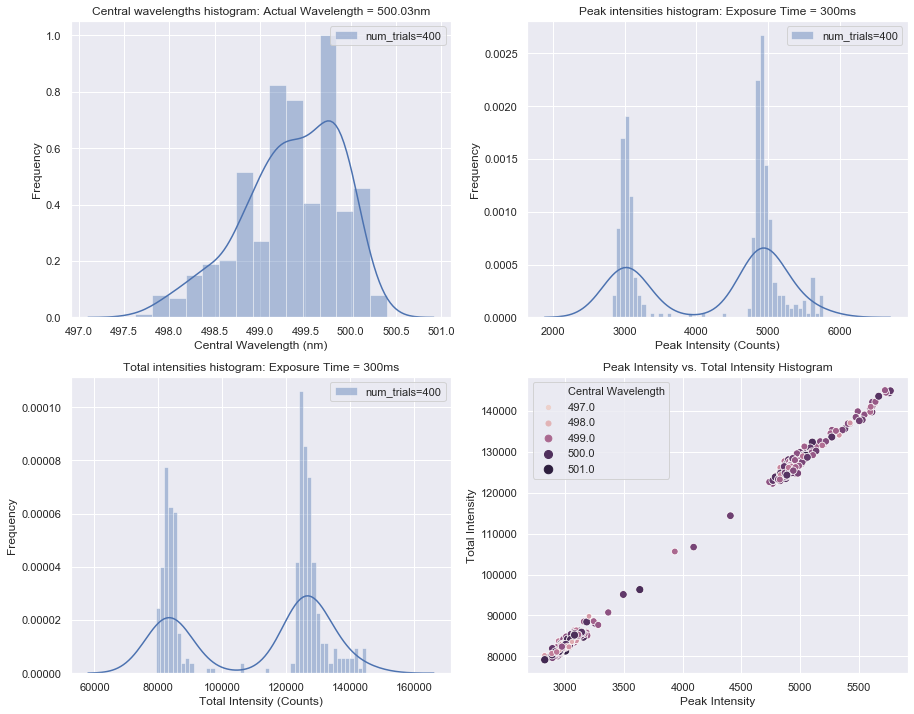

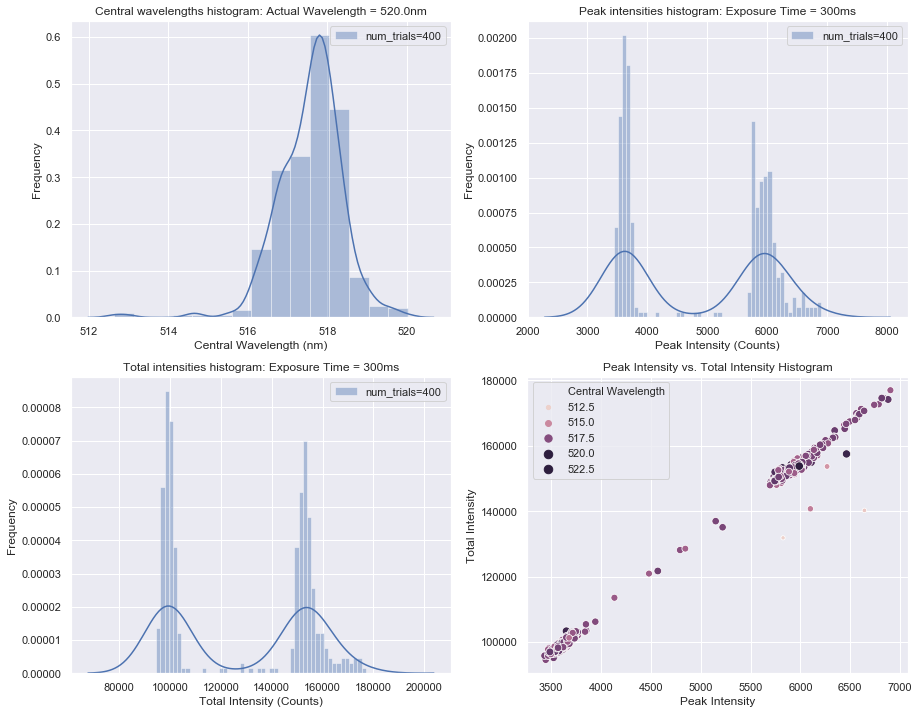

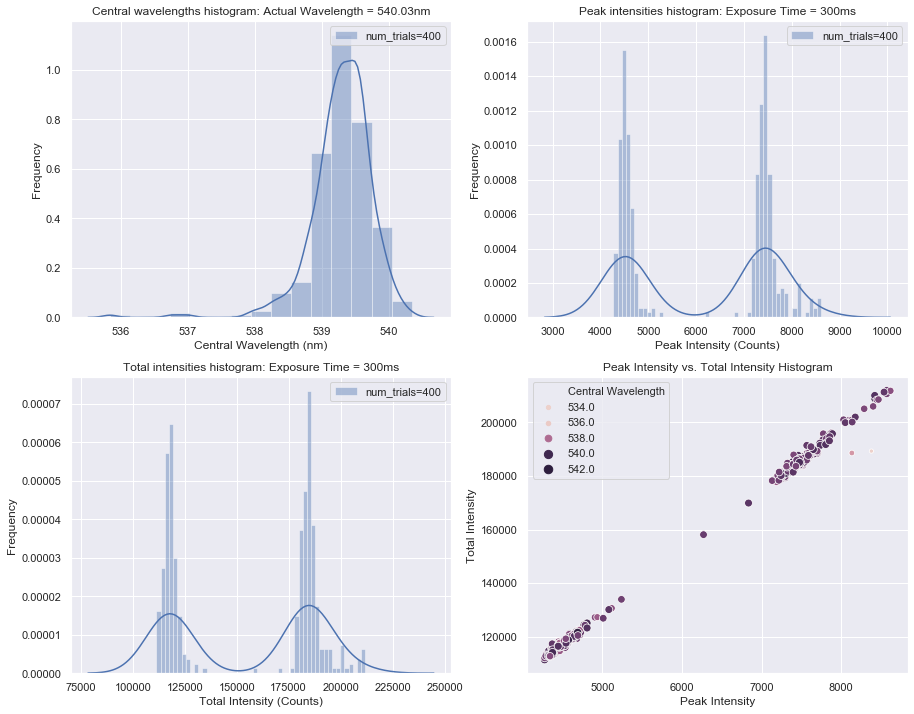

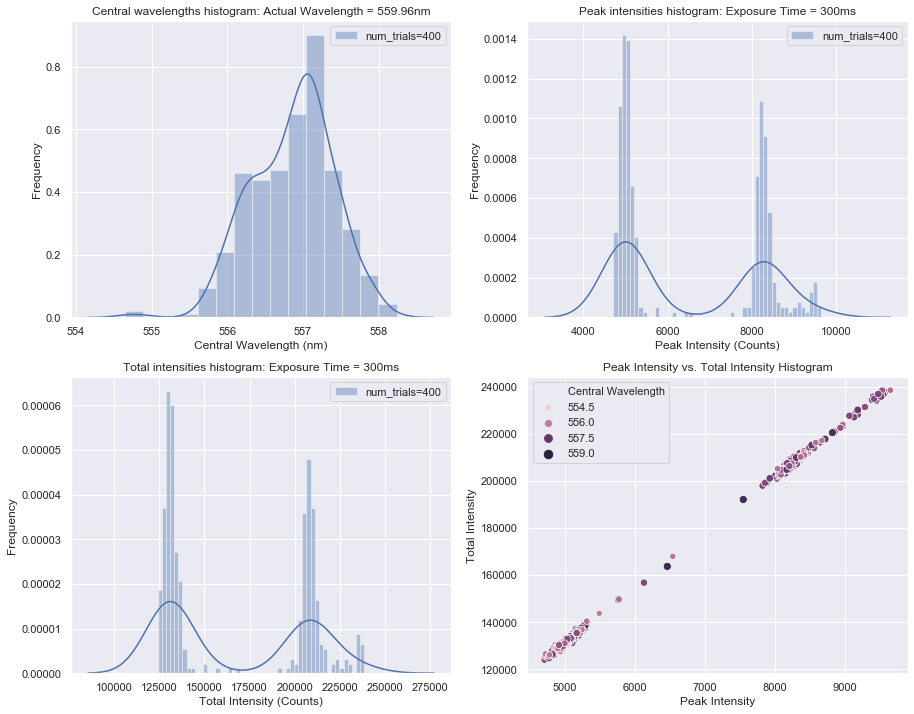

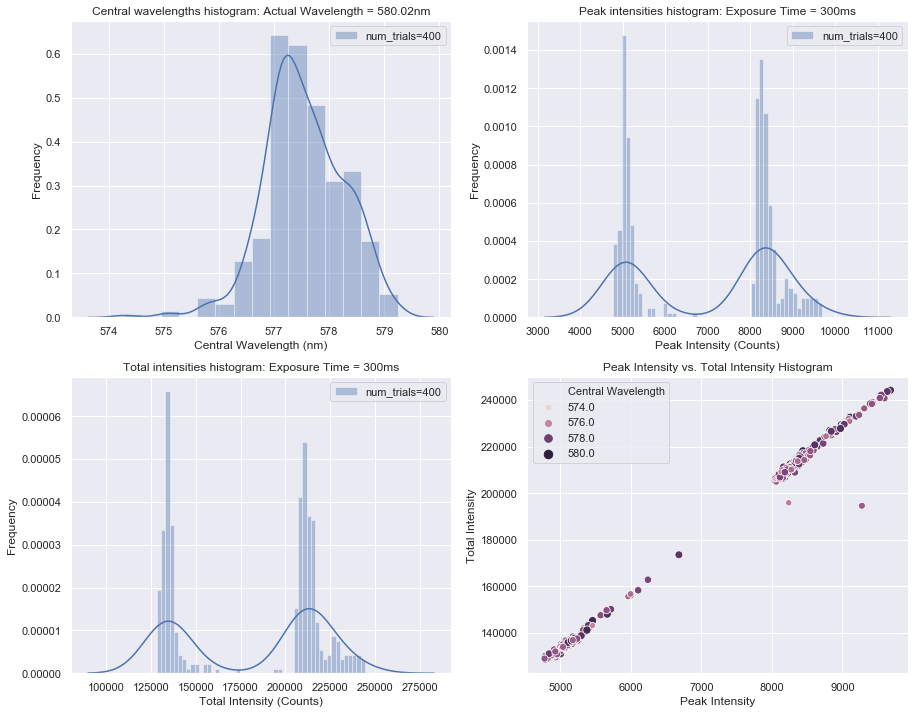

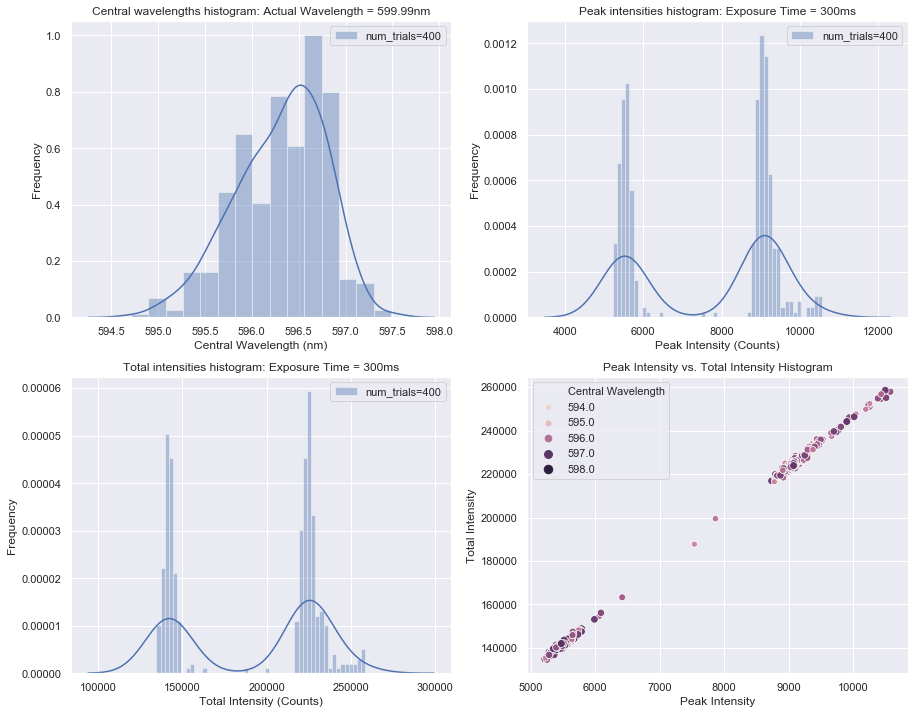

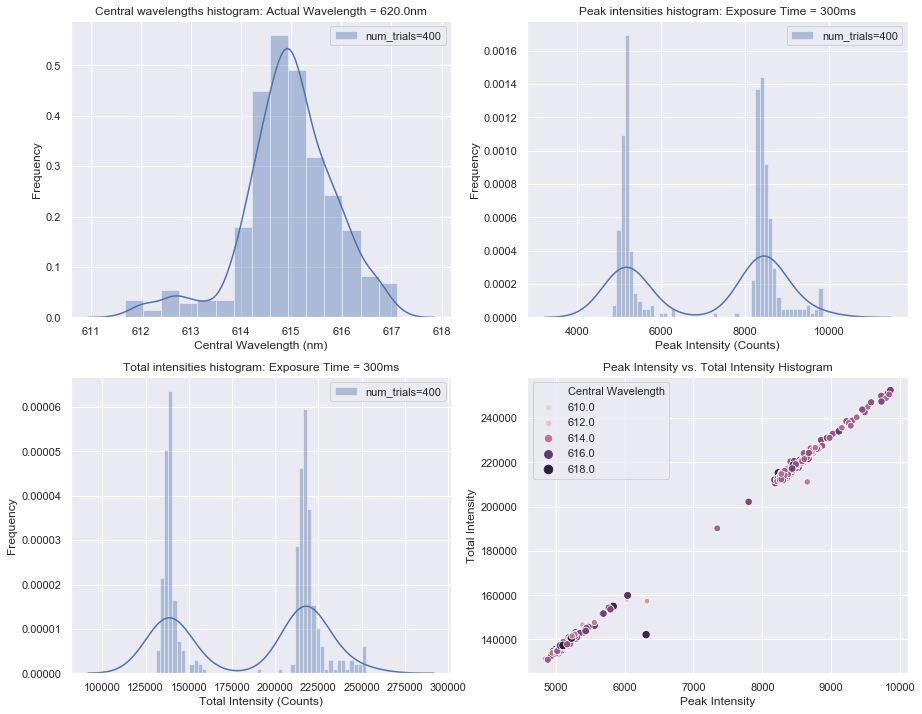

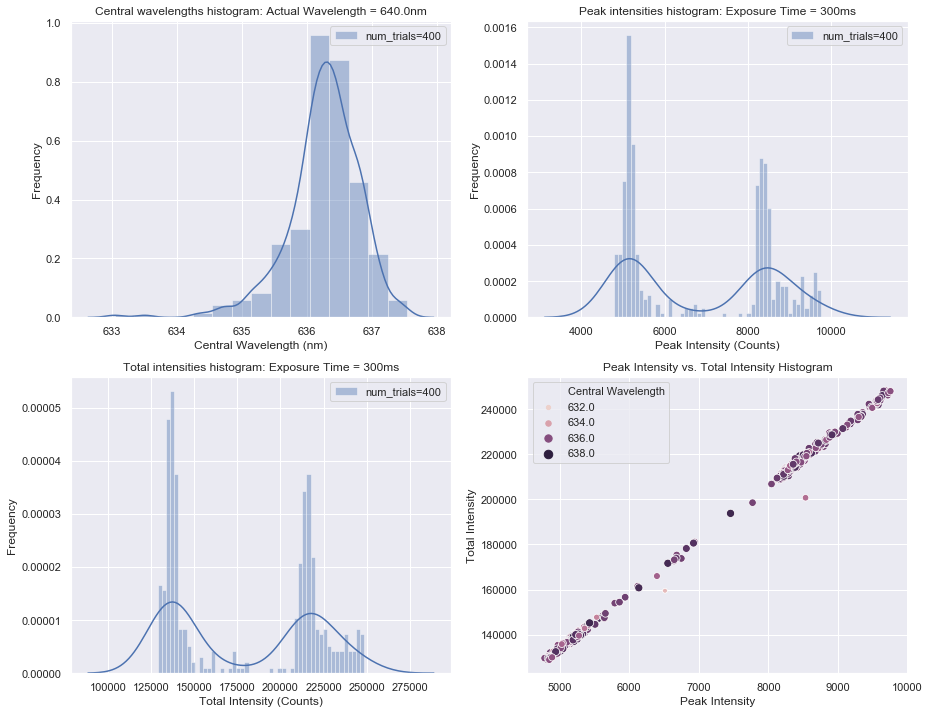

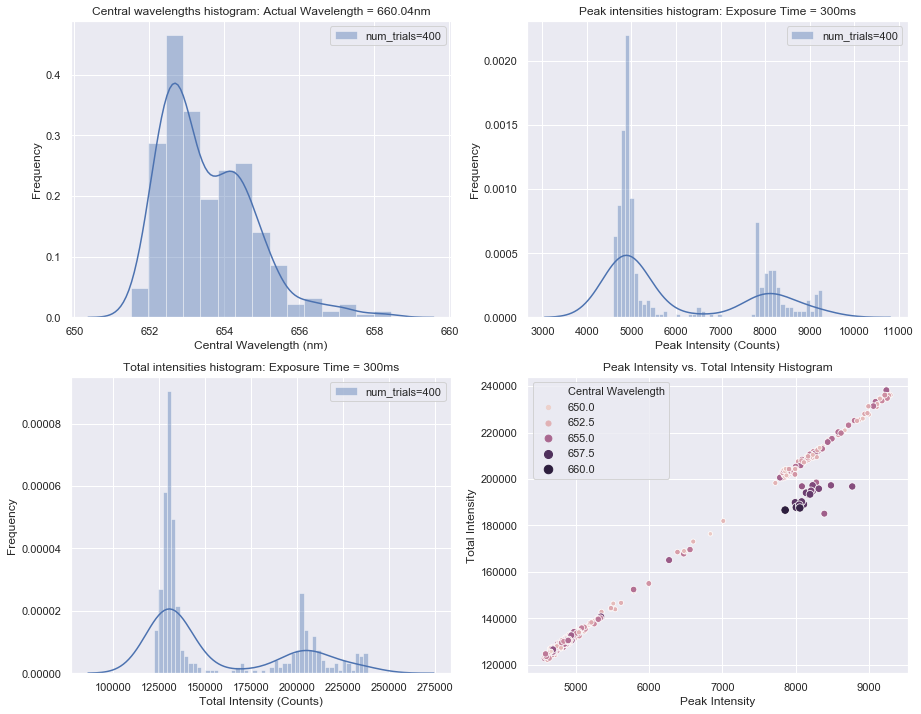

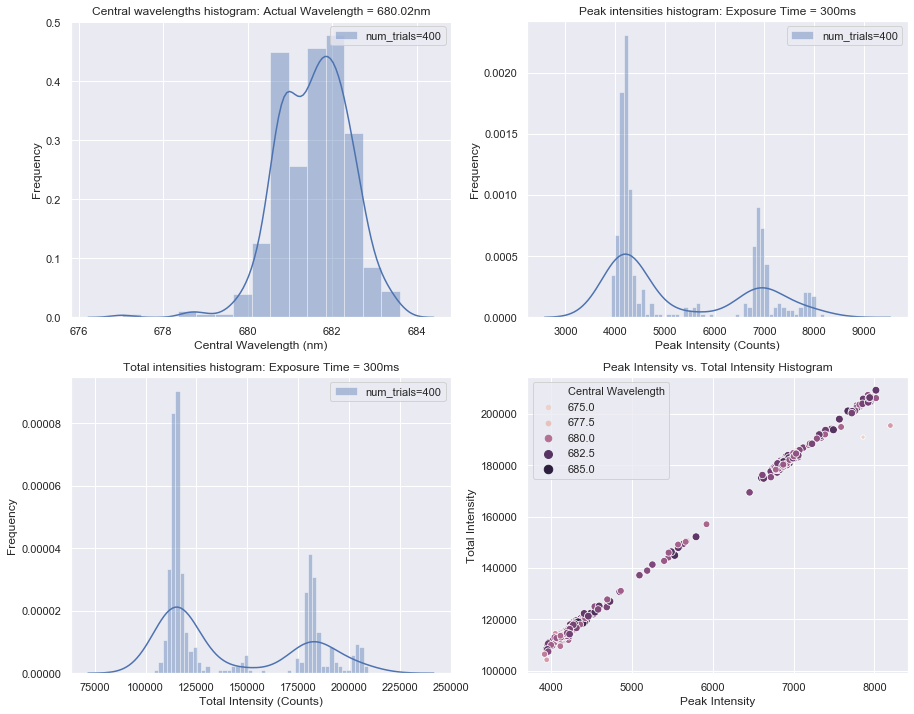

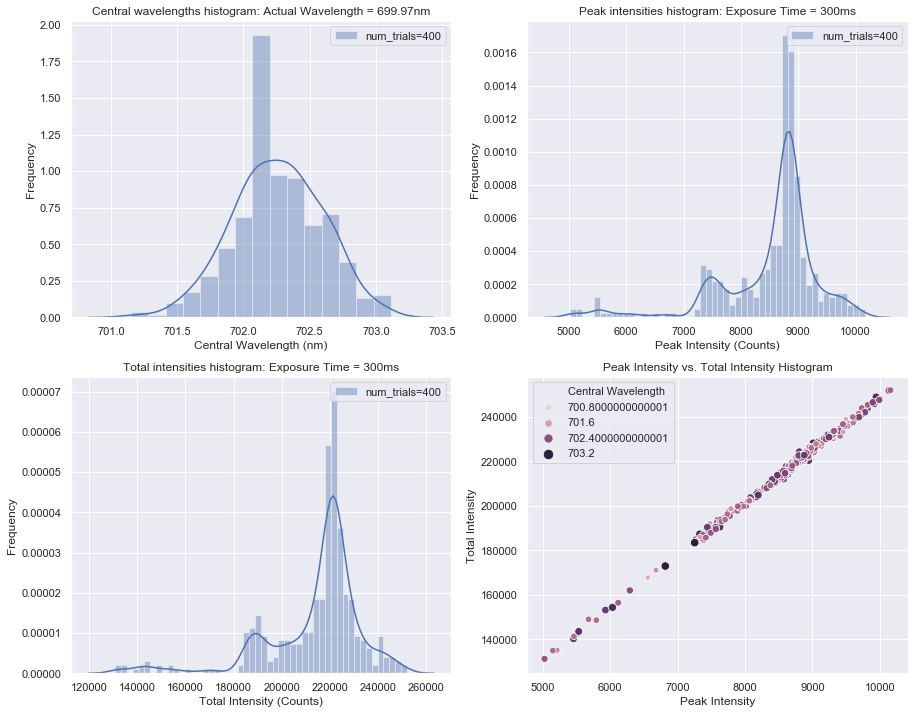

In [7]:
from calibration.spectrometer import run_spectrometer
run_spectrometer(wls, trials, exposure)

## 2. Intensity 

- Find the output intensity as a function of central wavelength
- Find the bias vs. variance trade off

In [7]:
repeat = 50 

In [8]:
trials = 20 
pause = 0
run_measure_intensities(trials, pause, wls, exposure, repeat)

NameError: name 'run_measure_intensities' is not defined

## 2. Experiment: Spectral Profile

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from calibration.monochromator import intensity_density, intensity_integral

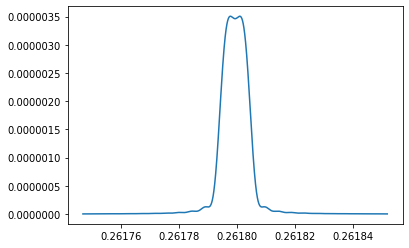

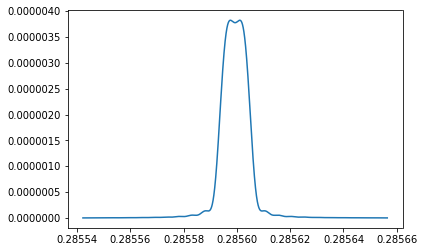

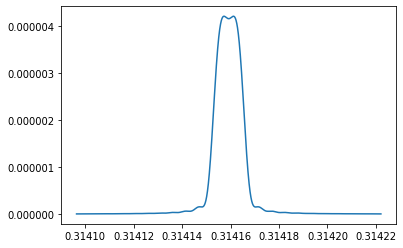

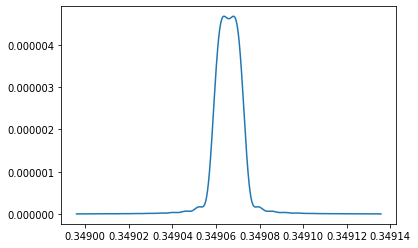

In [2]:
lambda_over_d_central_all = [np.pi/12, np.pi/11, np.pi/10, np.pi/9]
slit_width = 0.00002
for lambda_over_d_central in lambda_over_d_central_all:
    lambda_over_d_all, integral_all = intensity_integral(slit_width, lambda_over_d_central)
    plt.plot(lambda_over_d_all, integral_all)
    plt.show()

In [22]:
theta = np.linspace(-np.pi, np.pi, 1000000)
intensity_list = []
for i in theta: 
    intensity = intensity_density(i, np.pi/6)
    intensity_list.append(intensity)
plt.figure(figsize = (12, 8))
plt.plot(theta, intensity_list)

In [2]:
from calibration.stability import run_test_spectrometer

/Users/mingyu/Desktop/OPMD_acq/OPMD_acq/testbench_funcs.py:97: UserWarning: no Archon connected to server, CCD functionality will be disabled...
  warn("no Archon connected to server, CCD functionality will be disabled...")



Current Time 2020-02-05 14:35:37.018550 Working on trial 0
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:38.702703 Working on trial 1
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:40.457344 Working on trial 2
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:42.081525 Working on trial 3
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:43.788089 Working on trial 4
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:45.459361 Working on trial 5
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:47.305321 Working on trial 6
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:49.124214 Working on trial 7
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:50.857720 Working on trial 8
Getting spectrum and power for wavelength: 600.00

Current T


Current Time 2020-02-05 14:37:47.318182 Working on trial 74
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:37:49.184801 Working on trial 75
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:37:50.800426 Working on trial 76
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:37:52.637579 Working on trial 77
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:37:54.789706 Working on trial 78
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:37:56.837567 Working on trial 79
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:37:58.681157 Working on trial 80
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:38:00.423851 Working on trial 81
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:38:02.160954 Working on trial 82
Getting spectrum and power for wavelength: 600.00




Current Time 2020-02-05 14:40:04.669354 Working on trial 148
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:06.975758 Working on trial 149
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:09.316847 Working on trial 150
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:10.981120 Working on trial 151
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:12.732303 Working on trial 152
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:14.564026 Working on trial 153
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:16.307026 Working on trial 154
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:17.944091 Working on trial 155
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:19.783869 Working on trial 156
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:42:24.304916 Working on trial 222
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:26.455212 Working on trial 223
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:28.194702 Working on trial 224
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:30.038919 Working on trial 225
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:31.880713 Working on trial 226
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:33.930963 Working on trial 227
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:35.812415 Working on trial 228
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:37.519613 Working on trial 229
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:39.629981 Working on trial 230
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:44:39.140354 Working on trial 296
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:41.211435 Working on trial 297
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:43.374725 Working on trial 298
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:45.217845 Working on trial 299
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:47.160246 Working on trial 300
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:49.244168 Working on trial 301
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:50.949763 Working on trial 302
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:52.606594 Working on trial 303
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:54.728588 Working on trial 304
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:47:04.469230 Working on trial 370
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:06.716811 Working on trial 371
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:08.511404 Working on trial 372
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:10.197220 Working on trial 373
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:12.042895 Working on trial 374
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:13.894255 Working on trial 375
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:15.640017 Working on trial 376
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:18.932812 Working on trial 377
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:21.369609 Working on trial 378
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:49:28.746686 Working on trial 444
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:30.487228 Working on trial 445
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:32.328842 Working on trial 446
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:34.170468 Working on trial 447
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:35.783771 Working on trial 448
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:37.450342 Working on trial 449
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:39.188671 Working on trial 450
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:40.921209 Working on trial 451
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:42.574914 Working on trial 452
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:51:38.172706 Working on trial 518
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:39.977768 Working on trial 519
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:41.552250 Working on trial 520
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:43.266777 Working on trial 521
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:44.931481 Working on trial 522
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:46.466446 Working on trial 523
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:48.313782 Working on trial 524
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:49.781073 Working on trial 525
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:51.904782 Working on trial 526
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:53:49.140824 Working on trial 592
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:53:50.782026 Working on trial 593
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:53:52.521525 Working on trial 594
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:53:54.230078 Working on trial 595
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:53:56.005669 Working on trial 596
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:53:57.747822 Working on trial 597
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:53:59.551656 Working on trial 598
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:54:01.226000 Working on trial 599
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:54:03.068589 Working on trial 600
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:55:59.493143 Working on trial 666
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:01.236941 Working on trial 667
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:02.943744 Working on trial 668
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:04.587489 Working on trial 669
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:06.149351 Working on trial 670
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:07.790226 Working on trial 671
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:09.632718 Working on trial 672
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:11.155798 Working on trial 673
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:13.013279 Working on trial 674
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:58:06.768183 Working on trial 740
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:08.271562 Working on trial 741
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:10.259424 Working on trial 742
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:12.103264 Working on trial 743
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:13.844076 Working on trial 744
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:15.584061 Working on trial 745
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:17.325389 Working on trial 746
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:19.237379 Working on trial 747
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:20.882444 Working on trial 748
Getting spectrum and power for wavelength:


Current Time 2020-02-05 15:00:14.978309 Working on trial 814
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:16.890945 Working on trial 815
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:18.769013 Working on trial 816
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:20.511071 Working on trial 817
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:22.147646 Working on trial 818
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:23.989167 Working on trial 819
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:25.629051 Working on trial 820
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:27.469449 Working on trial 821
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:29.224207 Working on trial 822
Getting spectrum and power for wavelength:


Current Time 2020-02-05 15:02:19.495829 Working on trial 888
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:21.021118 Working on trial 889
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:22.495477 Working on trial 890
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:23.973764 Working on trial 891
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:25.541581 Working on trial 892
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:27.188323 Working on trial 893
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:28.818397 Working on trial 894
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:30.350557 Working on trial 895
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:32.384019 Working on trial 896
Getting spectrum and power for wavelength:


Current Time 2020-02-05 15:04:24.321483 Working on trial 962
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:26.164767 Working on trial 963
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:27.902911 Working on trial 964
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:29.745542 Working on trial 965
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:31.793679 Working on trial 966
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:33.355312 Working on trial 967
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:34.885053 Working on trial 968
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:36.356615 Working on trial 969
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:37.852370 Working on trial 970
Getting spectrum and power for wavelength:

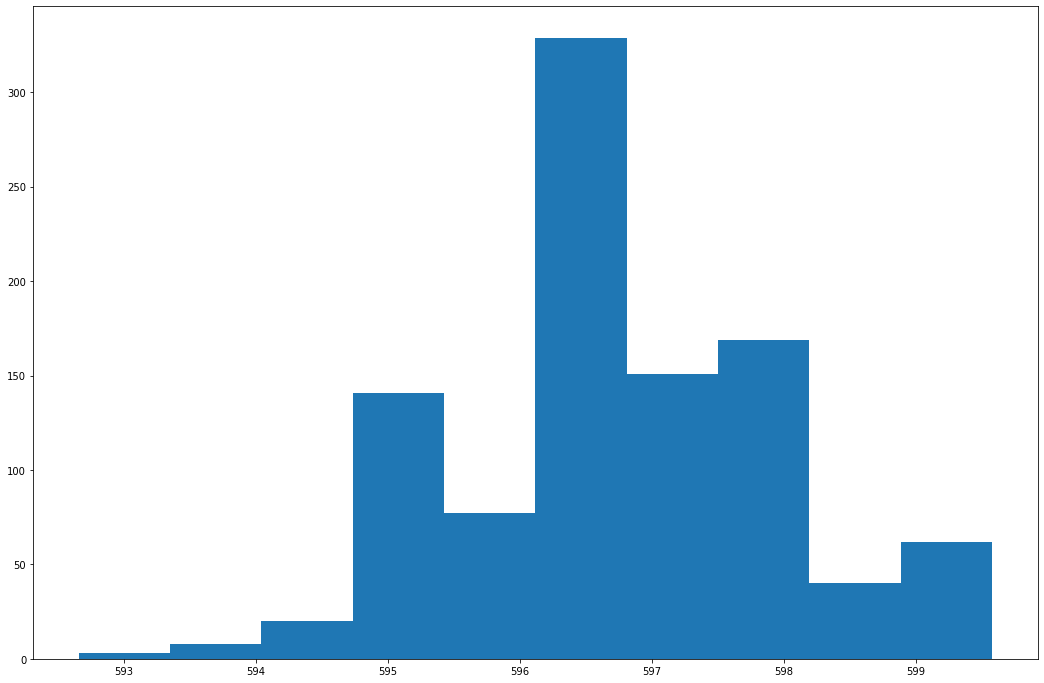

In [4]:
trials = 1000
wls = [600]
exposure = 300
repeat = 1
central_wl_trials, fig = run_test_spectrometer(trials, wls, exposure, repeat)

- The integral doesn't converge -> use a small value in denomenator 
- The linspace is not fine enough 

In [1]:
import matplotlib.pyplot as plt
from experiment.experiment import tb
from scipy.signal import medfilt
import numpy as np
from scipy.signal import butter
from scipy.signal import filtfilt
# wls, spec, spec_s = tb.read_smooth_spectrum(300)
# tb.set_lamp_current(10.0)
# print(tb.get_lamp_current())
wls, spec, base_filter_spec, wls_, spec_ = tb.read_smooth_spectrum(300)


/Users/mingyu/Desktop/OPMD_acq/OPMD_acq/testbench_funcs.py:99: UserWarning: no Archon connected to server, CCD functionality will be disabled...
  warn("no Archon connected to server, CCD functionality will be disabled...")


164.02680455030102


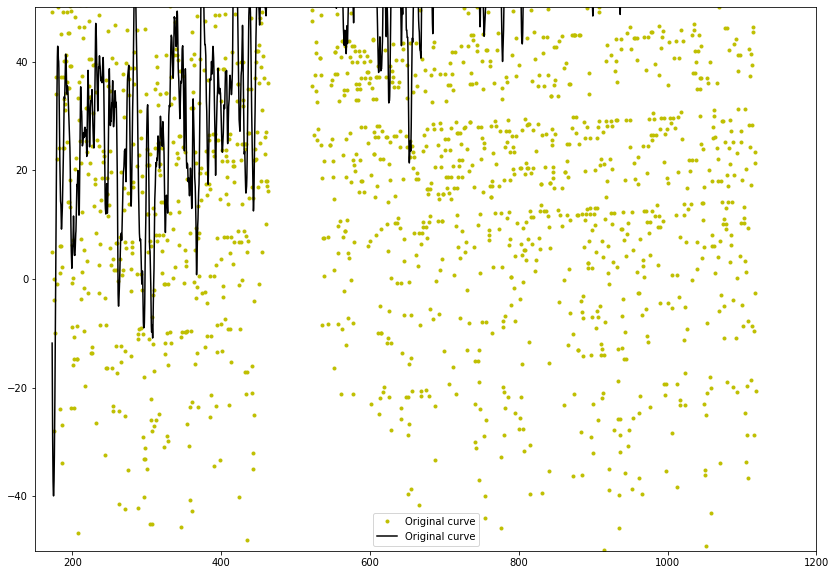

In [4]:
fig = plt.figure(figsize=(14, 10))

plt.plot(wls, spec-baseline, 'y.', label= 'Original curve')
plt.plot(wls_, spec_, 'k-', label= 'Original curve')
plt.legend(loc='best')
# plt.xlim(150, 1200)
# plt.ylim(-50, 50)
plt.legend(loc='best')

In [12]:
import numpy as np 
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)
y = np.array([2, 2, 5, 2, 1, 0, 1, 4, 9])
y_filtered = savgol_filter(y, 5, 2, deriv = 0)
y_filtered_near = savgol_filter(y, 5, 2, mode = 'nearest')

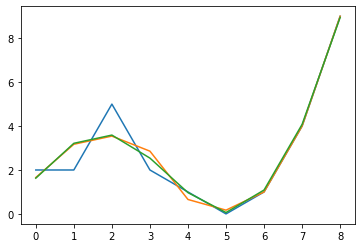

In [14]:
plt.plot(y)
plt.plot(y_filtered)
plt.plot(savgol_filter(y_filtered, 5, 2, deriv = 0))

In [11]:
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


AttributeError: 'Figure' object has no attribute 'fig'

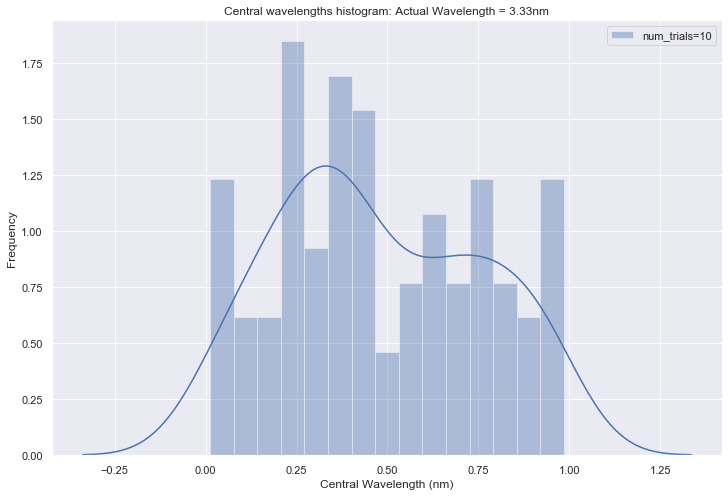

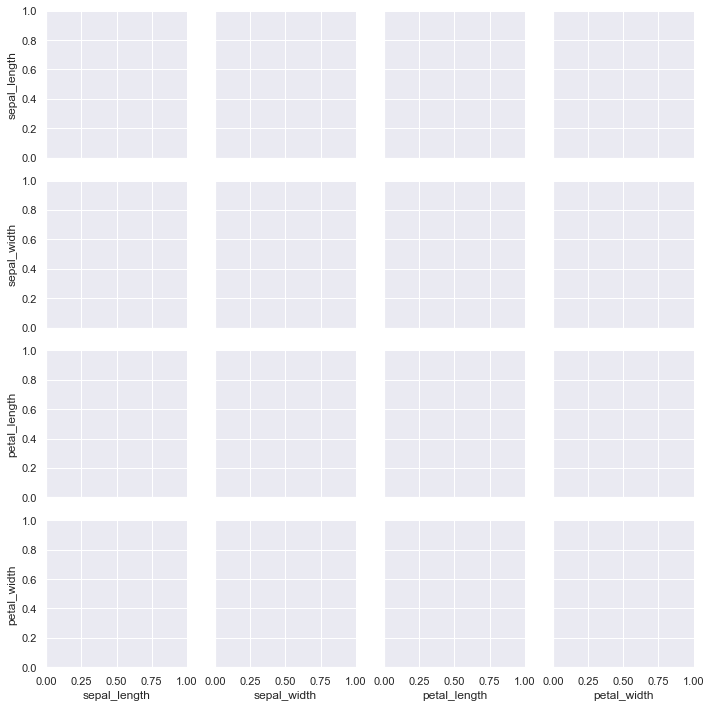

<Figure size 1152x576 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tools.SeabornFig2Grid as sfg
import numpy as np
sns.set()

iris = sns.load_dataset("iris")
tips = sns.load_dataset("tips")

# An lmplot
fig, ax = plt.subplots(figsize=(12, 8))
central_wl_trials = np.random.random(100)
sns.distplot(central_wl_trials, bins=15, label=f'num_trials={trials}', ax=ax)
ax.set_xlabel('Central Wavelength (nm)')
ax.set_ylabel('Frequency')
ax.legend(loc='upper right')
ax.set_title(f'Central wavelengths histogram: Actual Wavelength = {round(3.33, 2)}nm')
g0 = fig
# A PairGrid
g1 = sns.PairGrid(iris, hue="species")

fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(1, 2)
gs.tight_layout(fig)

sfg.SeabornFig2Grid(g0, fig, gs[0])
sfg.SeabornFig2Grid(g1, fig, gs[1])


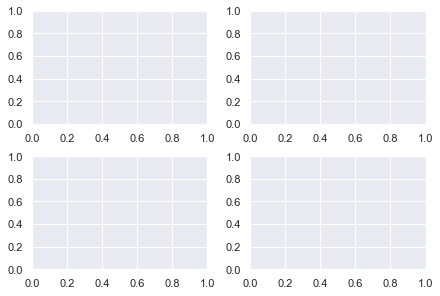

In [20]:
fig = plt.figure(constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
f2_ax1 = fig.add_subplot(spec2[0, 0])
f2_ax2 = fig.add_subplot(spec2[0, 1])
f2_ax3 = fig.add_subplot(spec2[1, 0])
f2_ax4 = fig.add_subplot(spec2[1, 1])


In [14]:
from datetime import datetime
d1 = datetime.now()

In [15]:
d2 = datetime.now()
d = d2-d1

In [18]:
round(d.total_seconds(), 2)

5.52

In [18]:
import time 
from datetime import datetime
times = []
for i in range(10): 
    times.append(datetime.now())
    time.sleep(1)

In [14]:
import numpy as np 
diff_times = [0] + [diff_time.total_seconds() for diff_time in np.diff(times)]
sum_times = [round(cum_time, 2) for cum_time in np.cumsum(diff_times)]

In [28]:
[round((time-times[0]).total_seconds(), 2) for time in times]

[0.0, 1.01, 2.01, 3.01, 4.01, 5.02, 6.02, 7.02, 8.02, 9.02]

In [24]:
seconds = round((times-times[0]).total_seconds(), 2)

TypeError: unsupported operand type(s) for -: 'list' and 'datetime.datetime'

In [4]:
import numpy as np
a = np.arange(100).reshape(10, 5, 2)
np.shape(a[:, 2, :])

(10, 2)

In [2]:
import numpy as np
from scipy.integrate import simps
actualwls_trials = np.arange(50).reshape(10, 5)
measured_lights_trials = np.arange(50).reshape(10, 5)
ambient_lights_trials = np.arange(50).reshape(10, 5)
specwls_trials = np.arange(100).reshape(10, 5, 2)
specs_trials = np.arange(100).reshape(10, 5, 2)

In [4]:
actualwls = np.mean(actualwls_trials, axis=0)
for j in range(np.shape(actualwls_trials)[1]):
    actualwl = actualwls[j]
    measured_light_trials = measured_lights_trials[:, j]
    ambient_light_trials = ambient_lights_trials[:, j]
    specwl_trials = specwls_trials[:, j, :]
    spec_trials = specs_trials[:, j, :]
    second_trails = specs_trials[:, j]

    central_wl_trails = specwl_trials[np.argmax(spec_trials, axis=-1)]
    print(np.shape(np.argmax(spec_trials, axis=-1).reshape(-1, 1)))
    print(np.shape(spec_trials))
    peak_spec_trials = spec_trials[np.argmax(spec_trials, axis=-1)]
    intensity_trials = [simps(spec_trials[i, :], specwl_trials[i, :]) for i in range(np.shape(actualwls_trials)[0])]

(10, 1)
(10, 2)
(10, 1)
(10, 2)
(10, 1)
(10, 2)
(10, 1)
(10, 2)
(10, 1)
(10, 2)
